<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab04/lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Supervised vs Unsupervised Anomaly Detection

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


## Task 1 - Dataset Characterization and Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, silhouette_samples, silhouette_score
from sklearn.utils import shuffle
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as mplcm


In [2]:
np.random.seed(42)

# import train and test json
train_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab04/train.csv'
test_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab04/test.csv'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

### 1.1 - Explore the dataset

**Q: What are your dataset characteristics? How many categorical and numerical attributes do you have? How are your `attack_label` and `binary_label` distributed?**


In [3]:
# Dataset shape and preview
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (18831, 43)
Test shape: (5826, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0


Categorical features (4): ['protocol_type', 'service', 'flag', 'label']
Numerical features (39): ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'binary_label']
Cardinality of label:
label
normal    13448
dos        2913
probe      2289
r2l         181
Name: count, dtype: int64

Cardinality of binary_label:
binary_label
0    13448
1     5383
Name: count

/tmp/ipykernel_1095982/2408092939.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


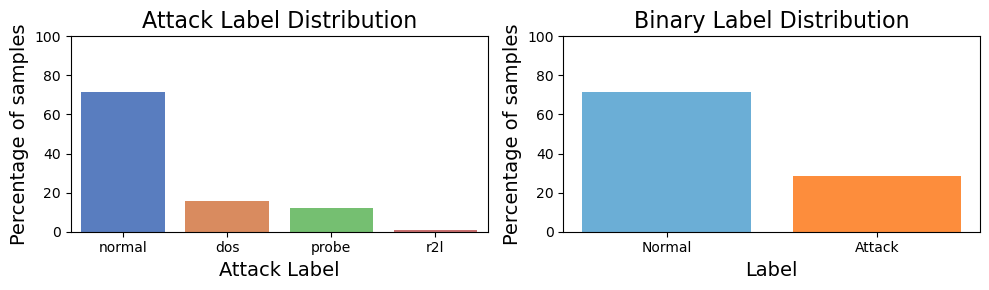

In [4]:
# Distinguish column types
categorical_cols = train_df.select_dtypes(include='object').columns.tolist()
numerical_cols = train_df.select_dtypes(exclude='object').columns.tolist()

print(f"Categorical features ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical features ({len(numerical_cols)}):", numerical_cols)

title_font = 16
label_font = 14

# Label distributions
print("Cardinality of label:")
print(train_df['label'].value_counts())
print("\nCardinality of binary_label:")
print(train_df['binary_label'].value_counts())

# distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(
    ax=axes[0],
    x='label',
    data=train_df,
    order=train_df['label'].value_counts().index,
    palette='muted',
    stat='percent'         
)
axes[0].set_title('Attack Label Distribution',  fontsize=title_font)
axes[0].set_ylabel('Percentage of samples',     fontsize=label_font)
axes[0].set_xlabel('Attack Label',              fontsize=label_font)
axes[0].set_ylim(0, 100)                       

binary_pct = (
    train_df['binary_label']
      .value_counts(normalize=True)   
      .sort_index()
      * 100                           
)

axes[1].bar(['Normal', 'Attack'], binary_pct,
            color=['#6baed6', '#fd8d3c'])
axes[1].set_title('Binary Label Distribution',  fontsize=title_font)
axes[1].set_ylabel('Percentage of samples',     fontsize=label_font)
axes[1].set_xlabel('Label',                    fontsize=label_font)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()


**Answer:**  
- The dataset contains `4` categorical and `39` numerical features.  
- The attack labels are distributed across several categories: DoS, Probe, R2L and normal.  
- The binary_label column shows the split between normal (0) and anomalous (1) traffic.


### 1.2 - Preprocessing

Before applying any machine learning or deep learning algorithms, it is essential to preprocess the data:
- **Categorical features** need to be converted to numerical values using encoding.
- **Numerical features** should be scaled to ensure uniformity.

**Q: How do you preprocess categorical and numerical data?**


Column 'protocol_type' has 3 unique values.


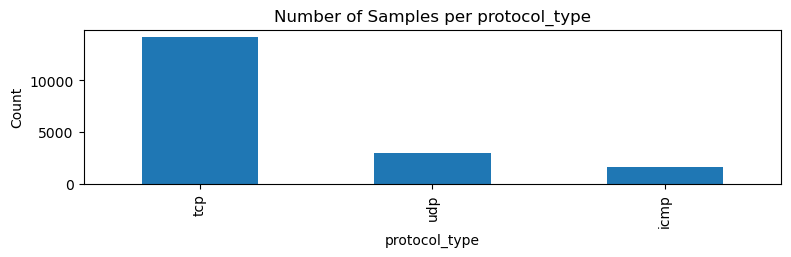

Column 'service' has 65 unique values.


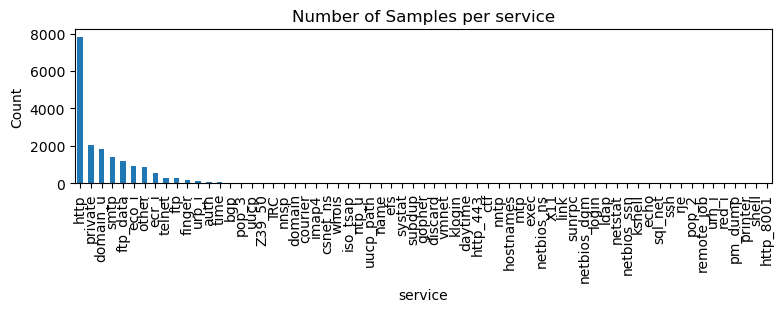

Column 'flag' has 11 unique values.


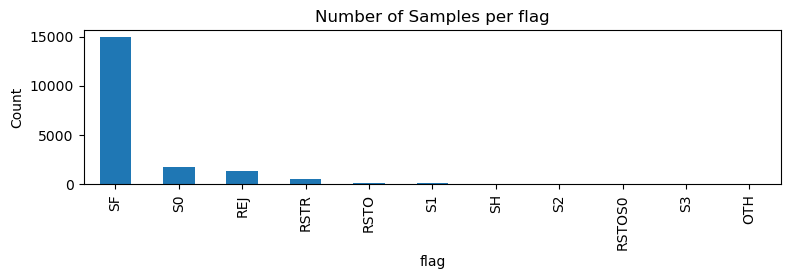

Column 'label' has 4 unique values.


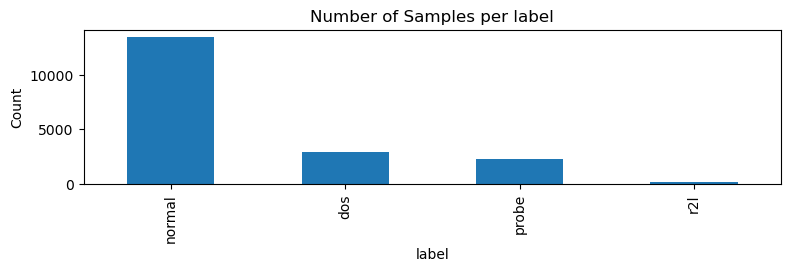

Unique value counts for categorical columns:
protocol_type     3
service          65
flag             11
label             4
dtype: int64


In [5]:
# Investigate categorical features
unique_counts = train_df[categorical_cols].nunique()

for col in categorical_cols:
    print(f"Column '{col}' has {unique_counts[col]} unique values.")
    train_df[col].value_counts().plot(kind="bar", figsize=(9, 2))
    plt.title(f"Number of Samples per {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()
    plt.close()

# Count how many unique values each categorical column has to decide on encoding
print("Unique value counts for categorical columns:")
print(unique_counts)

In [6]:
## Reduce categorical columns with high cardinality
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "telnet", "ftp"]
train_df['service'] = train_df['service'].apply(lambda x: x if x in allowed_services else 'other')
test_df['service'] = test_df['service'].apply(lambda x: x if x in allowed_services else 'other')

allowed_flag = ["SF", "S0", "REJ", "RSTR"]
train_df['flag'] = train_df['flag'].apply(lambda x: x if x in allowed_flag else 'other')
test_df['flag'] = test_df['flag'].apply(lambda x: x if x in allowed_flag else 'other')

In [7]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_df[categorical_cols[:3]])

encoded_df_cat= encoder.transform(train_df[categorical_cols[:3]])

def replace_categorical(df, encoded, cols):
    df_numeric = df.drop(columns=cols).reset_index(drop=True)
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cols))
    return pd.concat([df_numeric.reset_index(drop=True), encoded_df], axis=1)

df_encoded = replace_categorical(train_df, encoded_df_cat, categorical_cols[:3])

df_encoded

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_http,service_other,service_private,service_smtp,service_telnet,flag_REJ,flag_RSTR,flag_S0,flag_SF,flag_other
0,0,28,0,0,3,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,8,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,216,3396,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,348,277,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,328,1231,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18827,0,214,928,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18828,0,253,11905,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18829,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
features = df_encoded.drop(['label', 'binary_label'], axis=1)
labels = df_encoded['binary_label']  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)
X_scaled_df['label'] = df_encoded['label']  
X_scaled_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_other,service_private,service_smtp,service_telnet,flag_REJ,flag_RSTR,flag_S0,flag_SF,flag_other,label
0,-0.131577,-0.011662,-0.054860,-0.007287,9.982021,0.0,-0.105302,-0.022495,-1.056110,-0.025043,...,-0.472261,2.872110,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,dos
1,-0.131577,-0.011669,-0.054860,-0.007287,-0.100300,0.0,-0.105302,-0.022495,-1.056110,-0.025043,...,2.117473,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,probe
2,-0.131577,-0.011672,-0.054860,-0.007287,-0.100300,0.0,-0.105302,-0.022495,-1.056110,-0.025043,...,2.117473,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,3.109521,-1.949084,-0.127881,dos
3,-0.131577,-0.011595,0.002675,-0.007287,-0.100300,0.0,-0.105302,-0.022495,0.946871,-0.025043,...,-0.472261,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,normal
4,-0.131577,-0.011547,-0.050167,-0.007287,-0.100300,0.0,-0.105302,-0.022495,0.946871,-0.025043,...,-0.472261,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,-0.131577,-0.011554,-0.034004,-0.007287,-0.100300,0.0,-0.105302,-0.022495,0.946871,-0.025043,...,-0.472261,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,normal
18827,-0.131577,-0.011595,-0.039137,-0.007287,-0.100300,0.0,-0.105302,-0.022495,0.946871,-0.025043,...,-0.472261,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,normal
18828,-0.131577,-0.011581,0.146834,-0.007287,-0.100300,0.0,-0.105302,-0.022495,0.946871,-0.025043,...,-0.472261,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,-0.321593,0.513061,-0.127881,normal
18829,-0.131577,-0.011672,-0.054860,-0.007287,-0.100300,0.0,-0.105302,-0.022495,-1.056110,-0.025043,...,2.117473,-0.348176,-0.284603,-0.120155,-0.278894,-0.164645,3.109521,-1.949084,-0.127881,dos


**Answer:**  
- **Categorical data** is preprocessed using **One-Hot Encoding**.
- **Numerical data** is standardized using **StandardScaler**, which centers the data (mean = 0) and scales it to unit variance (std = 1).


### 1.3 - Domain Expert Heatmaps

As a domain expert, we study statistical properties of the dataset by attack label.  
We group the data by `label` and compute:
- **Mean**
- **Standard Deviation**
- **Median**

We visualize the results using heatmaps.

**Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?**


In [9]:
def plot_stat_heatmap(df, method: str, title: str):
    grouped = df.groupby('label').agg(method)
    plt.figure(figsize=(18, 5)) 
    sns.heatmap(
        grouped,
        cmap='YlGnBu',   
        cbar_kws={'label': method.title()},
        linewidths=0.3,  
        linecolor='grey'
    )
    plt.title(title, fontsize=18, pad=18)
    plt.xticks(rotation=90, ha='center', fontsize=12)
    plt.yticks(fontsize=15,rotation=0)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Attack Label', fontsize=14)
    plt.tight_layout()
    plt.show()

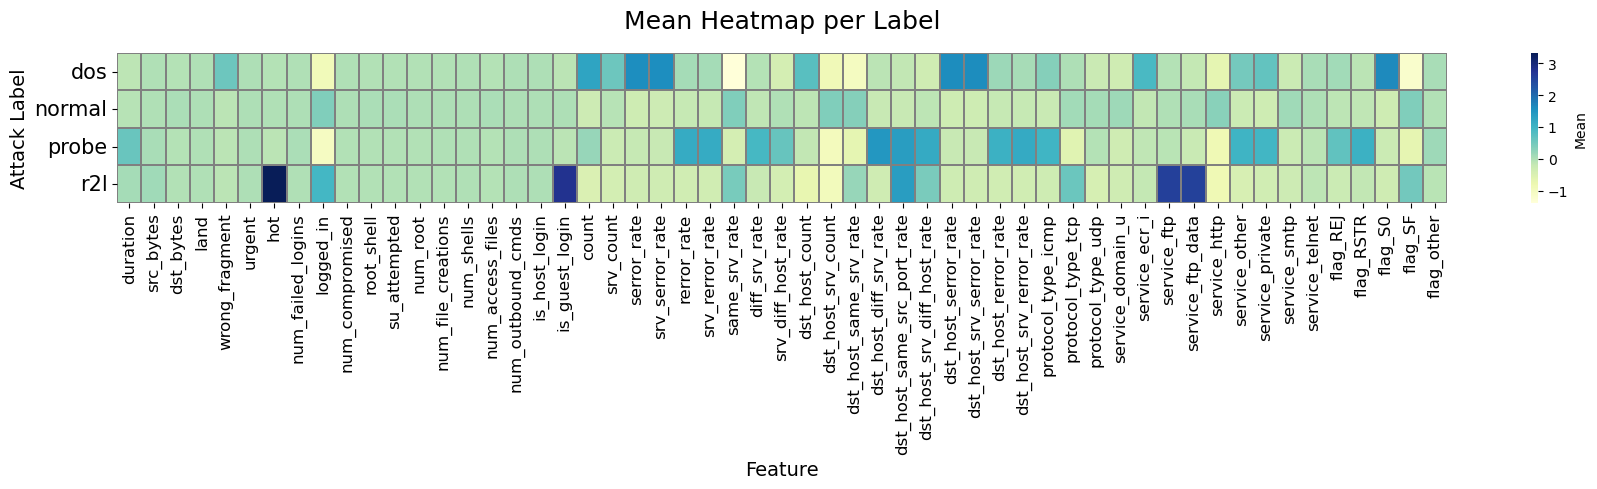

In [10]:
# Mean heatmap
plot_stat_heatmap(X_scaled_df, 'mean', 'Mean Heatmap per Label')

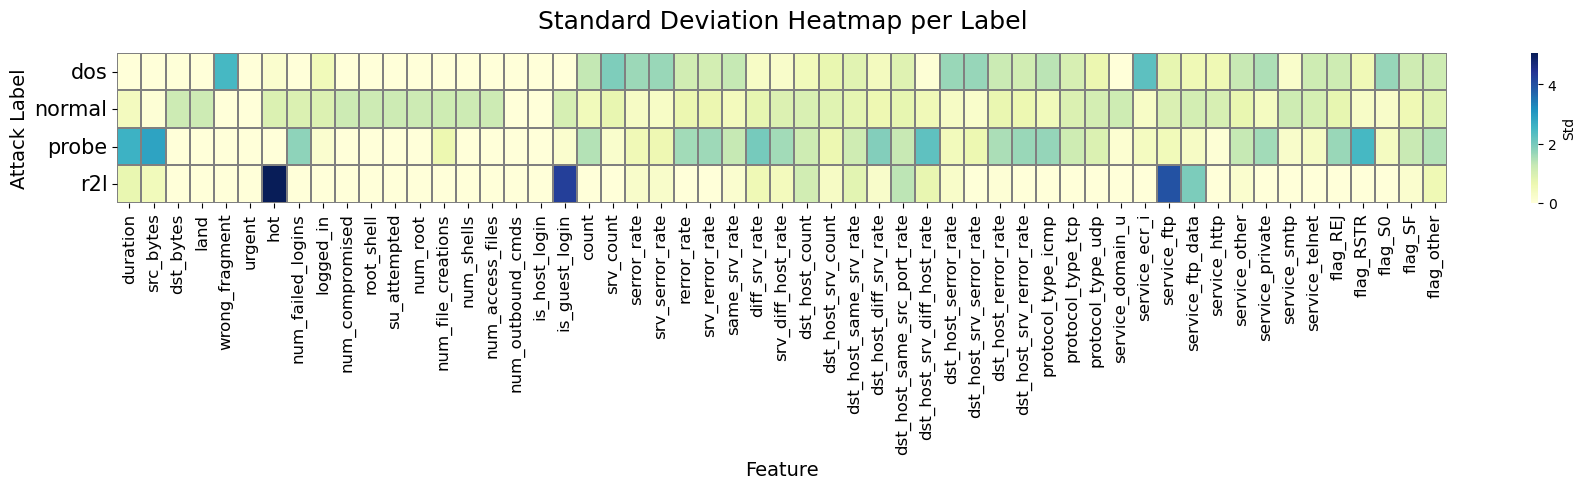

In [11]:
# Standard Deviation heatmap
plot_stat_heatmap(X_scaled_df, 'std', 'Standard Deviation Heatmap per Label')


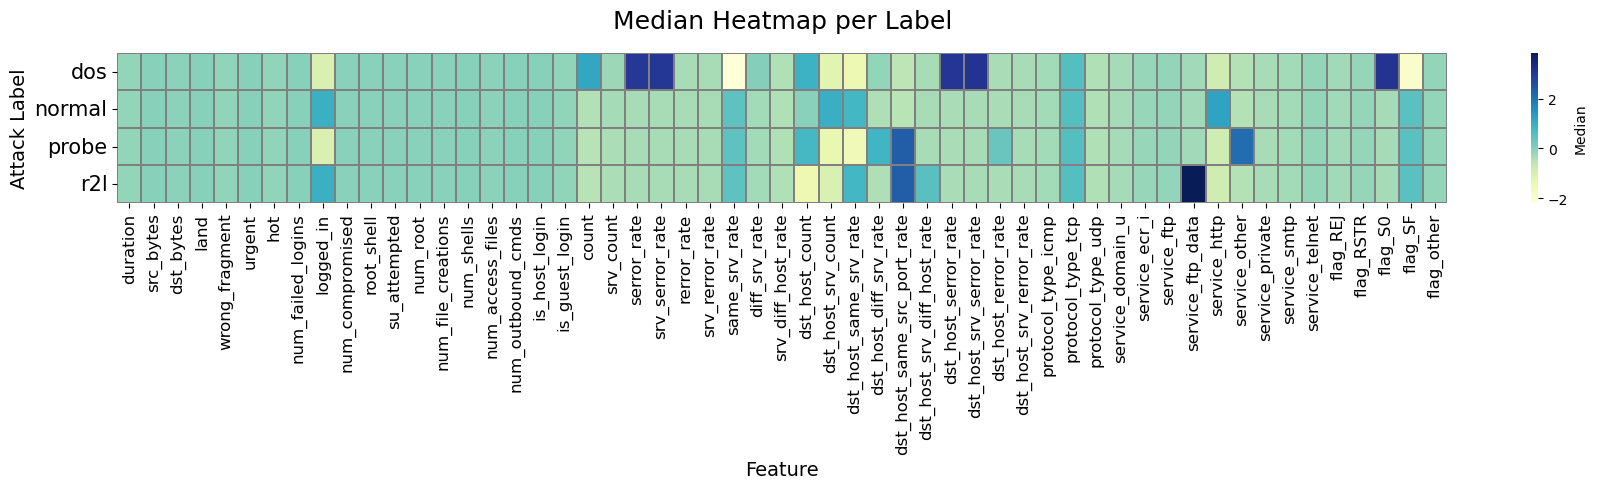

In [12]:
# Median heatmap
plot_stat_heatmap(X_scaled_df, 'median', 'Median Heatmap per Label')


**Answer**

By examining the heatmaps (mean, standard deviation, and median) grouped by `label`, we can identify meaningful patterns across different attack types:

- **R2L attacks (label 3)** show exceptionally high values and variance in features like `hot`, `is_guest_login`, `service_ftp` and `service_ftp_data`, which are intuitively linked to login attempts and access control violations.
- **DoS attacks (label 1)** display significant deviations in network traffic features such as `serror_rate`,`srv_serror_rate`, `dst_host_serror_rate`,`dst_host_srv_serror_rate` and `flag_S0`, indicating their flooding nature.
- **Probe attacks (label 2)** exhibit slightly elevated values in scanning-related features (e.g., `dst_host_same_src_port_rate`, `service_other`).

These patterns demonstrate that certain features are **strongly correlated with specific attacks**, providing useful insight for both supervised and unsupervised anomaly detection.


## Task 2 – One-Class SVM: Supervised vs Unsupervised Anomaly Detection

We will train several One-Class Support Vector Machine (OC-SVM) models to detect anomalies.

We will:
1. Train OC-SVM on normal data only (unsupervised)
2. Train OC-SVM on full data (semi-supervised)
3. Compare performance when including different amounts of anomalies
4. Evaluate the robustness on the test set

---


### 2.1 – OC-SVM on Normal Data Only

We train the model only on normal connections (binary_label = 0), as if we didn’t know about anomalies.

We use the `rbf` kernel and evaluate performance using F1-score.


In [13]:
X_norm = X_scaled_df[train_df['binary_label'] == 0].drop('label', axis=1)
y_full = train_df['binary_label'].values

X_all = X_scaled_df.drop('label', axis=1)

nu_estimate = 0.01  # estimated fraction of anomalies
ocsvm_normal = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_estimate)
ocsvm_normal.fit(X_norm)

y_pred_train = ocsvm_normal.predict(X_all)
y_pred_train = np.where(y_pred_train == -1, 1, 0)  # convert to 0=normal, 1=anomaly

f1_normal = f1_score(y_full, y_pred_train, average='macro')
print(f"OC-SVM (normal only) F1-macro: {f1_normal:.4f}")


OC-SVM (normal only) F1-macro: 0.9368


**Q: Considering that you are training only on normal data, which is a good estimate for the parameter `nu`? What is the impact on the training performance? Try both your estimate and the default value.**


In [14]:
ocsvm_default = OneClassSVM(kernel='rbf', gamma='scale')
ocsvm_default.fit(X_norm)
y_pred_default = np.where(ocsvm_default.predict(X_all) == -1, 1, 0)
f1_default = f1_score(y_full, y_pred_default, average='macro')
print(f"OC-SVM (default nu) F1-macro: {f1_default:.4f}")



OC-SVM (default nu) F1-macro: 0.6354


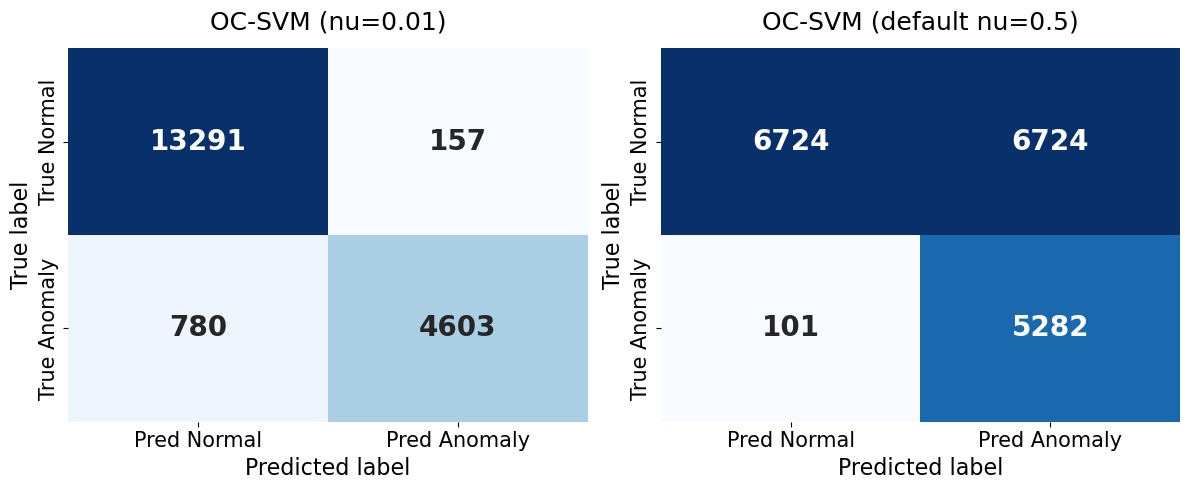

In [15]:
cm_normal = confusion_matrix(y_full, y_pred_train)
cm_default = confusion_matrix(y_full, y_pred_default)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

titles = [
    f"OC-SVM (nu={nu_estimate})",
    "OC-SVM (default nu=0.5)"
]
cms = [cm_normal, cm_default]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=['Pred Normal', 'Pred Anomaly'],
        yticklabels=['True Normal', 'True Anomaly'],
        ax=ax, annot_kws={'fontsize': 20, 'fontweight': 'bold'}
    )
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel('Predicted label', fontsize=16)
    ax.set_ylabel('True label', fontsize=16)
    ax.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.show()

**Answer:**

- A good estimate for `nu` is the expected fraction of anomalies in the training set. In this case, we use `nu = 0.01`, because normal data always contains error and 0 is not a good estimante.
- Using `nu=0.01` performs better than the default `nu=0.5`, which assumes 50% anomalies and overflags normal traffic.

Using `nu = 0.01` strikes a balance between sensitivity and specificity when training only on normal data.  
It allows the model to tolerate a small percentage of potential outliers, which aligns with the real-world assumption that most traffic is normal.


### 2.2 – One-Class SVM with All Data

Now we train the One-Class SVM on both **normal and anomalous data**.  
We estimate `nu` as the fraction of anomalies over the full dataset.

Then, we evaluate performance on the **same training data** to compare it with Task 2.1.


In [16]:
anomaly_ratio = train_df['binary_label'].sum() / len(train_df)
print(f"Estimated nu (anomaly ratio): {anomaly_ratio:.4f}")

ocsvm_all = OneClassSVM(kernel='rbf', gamma='scale', nu=anomaly_ratio)
ocsvm_all.fit(X_all)

y_pred_all = np.where(ocsvm_all.predict(X_all) == -1, 1, 0)
f1_all = f1_score(y_full, y_pred_all, average='macro')
print(f"OC-SVM (all data) F1-macro: {f1_all:.4f}")


Estimated nu (anomaly ratio): 0.2859
OC-SVM (all data) F1-macro: 0.7376


**Q: Which model performs better? Why do you think it is the case?**

**Answer:**

- The OC-SVM trained only on **normal data** (Task 2.1) performed better with an F1-macro of ~0.93, compared to the model trained on all data which scored ~`0.73`.
- This happens because including anomalous data in the training process **distorts the model's perception of "normal"**, making it harder to define a tight boundary around clean behavior.
- The OC-SVM assumes it is learning from **mostly normal data**, so it is more effective when trained on clean samples only.

Conclusion: For OC-SVM, **unsupervised training on normal traffic only** works better than mixing anomalies into the training set.


### 2.3 – One-Class SVM with Increasing Amounts of Anomalies

In this section, we train multiple OC-SVM models with different ratios of anomalous data added to the training set:
- 0%, 10%, 20%, 50%, 100%

For each setting, we compute and plot the F1-macro score to observe how the model performance is impacted by adding anomalies during training.


In [17]:
X_full = X_scaled_df.drop('label', axis=1)
y_full = train_df['binary_label'].values

X_normal = X_full[train_df['binary_label'] == 0]
X_anomalies = X_full[train_df['binary_label'] == 1]

ratios = [0.0, 0.1, 0.2, 0.5, 1.0]
f1_scores = []

print("One-Class SVM - F1 scores by anomaly ratio in training:\n")

for ratio in ratios:
    n_anomalies = int(ratio * len(X_anomalies))
    X_anom_part = X_anomalies.iloc[:n_anomalies]

    X_train_subset = pd.concat([X_normal, X_anom_part])
    X_train_subset = shuffle(X_train_subset, random_state=42)

    nu_val = max(0.01, n_anomalies / len(X_train_subset))

    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_val)
    model.fit(X_train_subset)

    y_pred = np.where(model.predict(X_full) == -1, 1, 0)
    f1 = f1_score(y_full, y_pred, average='macro')
    f1_scores.append(f1)

    print(f"-> {int(ratio * 100):>3}% anomalies → nu = {nu_val:.3f} → F1-macro = {f1:.4f}")




One-Class SVM - F1 scores by anomaly ratio in training:

->   0% anomalies → nu = 0.010 → F1-macro = 0.9377
->  10% anomalies → nu = 0.038 → F1-macro = 0.6593
->  20% anomalies → nu = 0.074 → F1-macro = 0.6740
->  50% anomalies → nu = 0.167 → F1-macro = 0.7198
-> 100% anomalies → nu = 0.286 → F1-macro = 0.7374


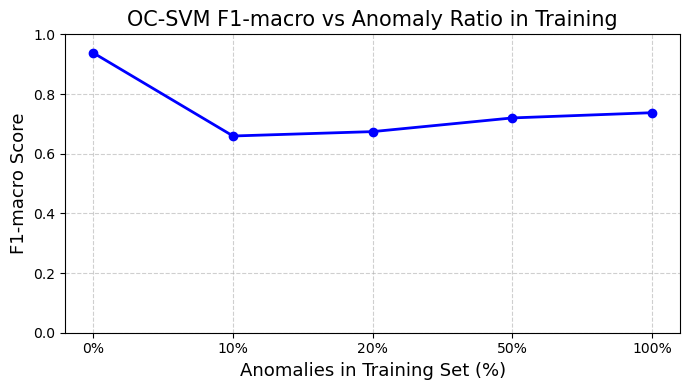

In [18]:
x_labels = [f"{int(r*100)}%" for r in ratios]

plt.figure(figsize=(7, 4))
plt.plot(x_labels, f1_scores, marker='o', linewidth=2, color='blue')
plt.xlabel('Anomalies in Training Set (%)', fontsize=13)
plt.ylabel('F1-macro Score', fontsize=13)
plt.title('OC-SVM F1-macro vs Anomaly Ratio in Training', fontsize=15)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Answer:**

As the percentage of anomalies in the training set increases, the performance of the OC-SVM model (measured by F1-macro) gradually decreases.

- When trained only on clean normal data (0%), the model performs best.
- Adding 10–50% anomalies begins to contaminate the training set and degrade the model’s ability to learn a tight boundary around normal behavior.
- At 100% anomalies, the model significantly underperforms.

This confirms that **OC-SVM is more effective when trained on purely normal traffic**, and that adding anomalies during training can mislead the model.


### 2.4 – OC-SVM Model Robustness (Test Set Evaluation)

In this final task, we test the robustness of the OC-SVM models on the **test set**.

We evaluate 3 models:
1. **Model 1 – trained only on normal data** (nu = 0.05)
2. **Model 2 – trained on all training data** (nu ≈ 0.2859)
3. **Model 3 – trained on normal + 10% anomalies** (nu ≈ 0.038)

We then compare the F1-macro scores on the **test set** to assess which model generalizes best.


In [19]:
encoded_test_df_cat = encoder.transform(test_df[categorical_cols[:3]])

def replace_categorical(df, encoded, cols):
    df_numeric = df.drop(columns=cols).reset_index(drop=True)
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cols))
    return pd.concat([df_numeric.reset_index(drop=True), encoded_df], axis=1)

encoded_test_df = replace_categorical(test_df, encoded_test_df_cat, categorical_cols[:3])


X_test_raw = encoded_test_df.drop(['label', 'binary_label'], axis=1)
X_test_scaled = scaler.transform(X_test_raw)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

y_test = test_df['binary_label'].values



In [20]:
model_normal = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
model_normal.fit(X_normal)

model_all = OneClassSVM(kernel='rbf', gamma='scale', nu=0.2859)
model_all.fit(X_full)

n_10 = int(0.1 * len(X_anomalies))
X_10 = pd.concat([X_normal, X_anomalies.iloc[:n_10]])
X_10 = shuffle(X_10, random_state=42)
nu_10 = n_10 / len(X_10)

model_10 = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_10)
model_10.fit(X_10)
print()
  

OC-SVM Test Set Evaluation:

Model 1 – Normal only               → Test F1-macro = 0.7888
Model 2 – All data                  → Test F1-macro = 0.6560
Model 3 – 10% anomalies             → Test F1-macro = 0.5073


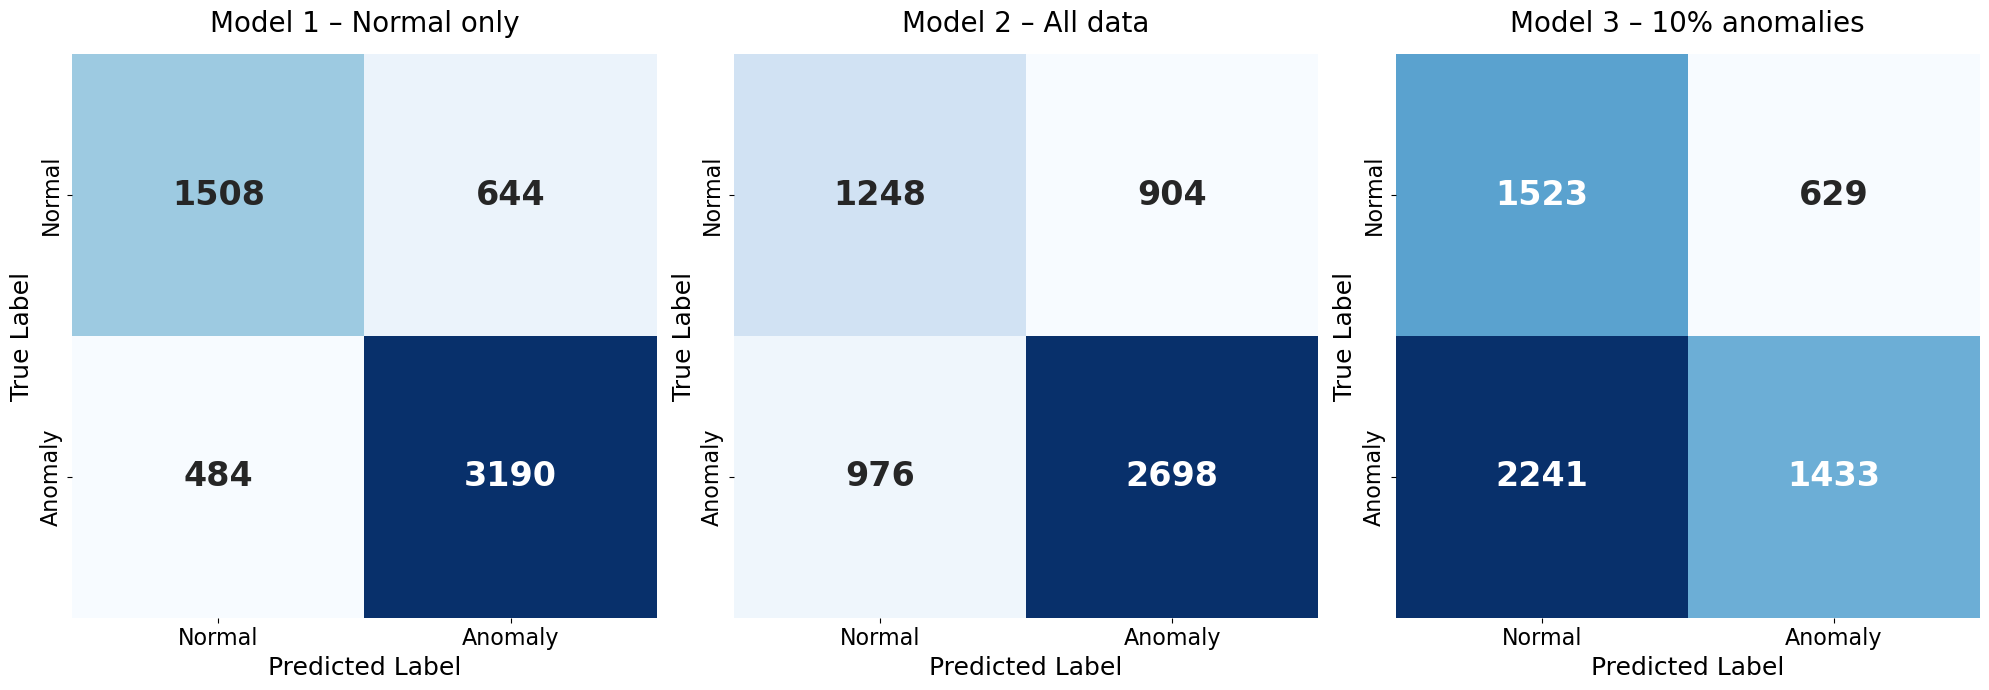

In [21]:
cm = {}
def evaluate_model(model, name):
    y_pred = np.where(model.predict(X_test) == -1, 1, 0)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name:<35} → Test F1-macro = {f1:.4f}")
    conf_matr = confusion_matrix(y_test, y_pred)
    cm[name] = conf_matr
    return f1

print("OC-SVM Test Set Evaluation:\n")
f1_test_normal = evaluate_model(model_normal, "Model 1 – Normal only")
f1_test_all    = evaluate_model(model_all,    "Model 2 – All data")
f1_test_10     = evaluate_model(model_10,     "Model 3 – 10% anomalies")

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for ax, (name, matrix) in zip(axes, cm.items()):
    sns.heatmap(
        matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
        xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
        annot_kws={'fontsize': 24, 'fontweight': 'bold'}
    )
    ax.set_title(name, fontsize=20, pad=16)
    ax.set_xlabel('Predicted Label', fontsize=18)
    ax.set_ylabel('True Label', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

On the test set, the three OC-SVM models showed **markedly different performances**:

- **Model 1 – Normal only:** F1-macro = **0.7888**
- **Model 2 – All data:** F1-macro = **0.6560**
- **Model 3 – 10% anomalies:** F1-macro = **0.5073**

This shows that the model trained **only on normal data (Model 1)** performs **best** on the test set, just as it did on the training set, although its performance drops from 0.93 (training) to 0.78 (test).
Including all anomalies in the training data (Model 2) or a small fraction (Model 3) actually **reduces the model’s ability to distinguish normal and anomalous traffic**.

Confusion Matrix Insights

- **Model 1 (Normal only):**
  * Best overall balance.
  * Correctly identifies most anomalies (**3190/3674**) and normal points (**1508/2152**).
  * Some false positives (normal as anomaly: 644) and false negatives (anomaly as normal: 484).
- **Model 2 (All data):**
  * Lower detection rates.
  * More normal samples misclassified as anomalies (**904**).
  * More anomalies missed (**976**).
- **Model 3 (10% anomalies):**
  * Poorest performance.
  * High false negatives for anomalies (**2241**), so many attacks are missed.
  * The classifier boundary is less effective when a small, potentially unrepresentative set of anomalies is used in training.

**Conclusions**

- **The best-performing model in the training set is also the best on the test set:** Model 1 (trained only on normal data).
- **Model 1 can still spot the majority of anomalies** and confuses normal data with anomalies less than the other models.
- **Model 2 and Model 3 both confuse more samples:** Including anomalies in training degrades OC-SVM’s sensitivity to true outliers, as the model boundary becomes less strict and more tolerant to attack-like patterns.

For One-Class SVM, training on clean, normal data gives the best generalization for detecting new or unseen anomalies in a realistic intrusion detection scenario.



## Task 3 – Deep Anomaly Detection and Data Representation

In this task, we extend the anomaly detection pipeline by introducing **Deep Learning** techniques, specifically using an **Autoencoder**.

We will:

1. Train and validate an Autoencoder on normal data only
2. Detect anomalies based on reconstruction error and thresholding
3. Represent data using the Autoencoder's bottleneck and apply OC-SVM
4. Compare the Autoencoder-based representation with PCA + OC-SVM

---

### Task 3.1 – Training and Validating Autoencoder with Normal Data Only

In this step, we train an Autoencoder using only normal traffic. The Autoencoder learns to reconstruct benign data with minimal error, which can later be used to detect anomalies.

The Autoencoder is composed of:
- An encoder that compresses the input into a lower-dimensional space (bottleneck)
- A decoder that reconstructs the input from the bottleneck representation

The model is trained on normal data only, split into training and validation sets.  
We monitor the reconstruction loss on the validation set to decide how many epochs to train and to evaluate model performance.


In [22]:
X_normal = X_scaled_df[train_df['binary_label'] == 0].drop('label', axis=1)

X_train_ae, X_val_ae = train_test_split(X_normal, test_size=0.3, random_state=42, shuffle=True)

X_tensor = torch.tensor(X_train_ae.values, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(X_tensor), batch_size=64)
X_val_tensor = torch.tensor(X_val_ae.values, dtype=torch.float32)
val_dataloader = DataLoader(TensorDataset(X_val_tensor), batch_size=64)

We define a feedforward Autoencoder with a symmetric structure and a bottleneck in the middle, with 8 dimensions.  
The reconstruction error will be measured using Mean Squared Error (MSE).


In [23]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, bottleneck_dim)
        )
        # Decoder: symmetric structure
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)     
        x_hat = self.decoder(z)
        return x_hat

    def encode(self, x):
        return self.encoder(x)  

def mixed_autoencoder_loss(x, x_recon, categorical_dims, numerical_idx):
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse = F.mse_loss(x_recon_num, x_num)

    ce = 0
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)

    return mse + ce


def compute_per_sample_reconstruction_error(x, x_recon, categorical_dims, numerical_idx):
    batch_size = x.shape[0]

    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse_per_sample = torch.mean((x_num - x_recon_num) ** 2, dim=1)

    ce_total = torch.zeros(batch_size, device=x.device)
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')  
        ce_total += ce

    return mse_per_sample + ce_total

all_columns = [col for col in train_df.columns if col not in ['label', 'binary_label']]

categorical_dims = []
for col in categorical_cols[:3]:  
    one_hot_cols = [c for c in all_columns if c.startswith(col + "_")]
    if one_hot_cols:
        start_idx = all_columns.index(one_hot_cols[0])
        end_idx = start_idx + len(one_hot_cols)
        categorical_dims.append((start_idx, end_idx))

numerical_idx = [i for i, col in enumerate(all_columns)
                if not any(col.startswith(c + "_") for c in categorical_cols[:3])]

def train_autoencoder(model, dataloader, val_dataloader, num_epochs=50, lr=0.001):
    print(f"\nTraining Autoencoder with {num_epochs} epochs and learning rate {lr}")
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience = 10
    wait = 0

    model.train()
    train_losses = []
    val_losses = []

    
    for epoch in range(num_epochs):
        train_loss = 0
        for batch in dataloader:
            x_batch = batch[0]
            optimizer.zero_grad()
            x_hat = model(x_batch)
            loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_tensor)
        train_losses.append(train_loss)  

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch in val_dataloader:
                x_val = val_batch[0]
                x_val_hat = model(x_val)
                loss = mixed_autoencoder_loss(x_val, x_val_hat, categorical_dims, numerical_idx)
                val_loss += loss.item() * x_val.size(0)
            val_loss /= len(X_val_ae)
            val_losses.append(val_loss)
        
        
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            wait = 0
            best_model_state = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    plt.figure(figsize=(4, 3)) 
    plt.plot(train_losses, label='Train', linewidth=1.8)
    plt.plot(val_losses, label='Val', linewidth=1.8)
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Loss', fontsize=11)
    plt.title('Loss', fontsize=13)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    model.load_state_dict(best_model_state)
    return model, best_val_loss, train_losses, val_losses



Training Autoencoder with 200 epochs and learning rate 0.001
Epoch 10/200, Train Loss: 0.0018, Val Loss: 0.1080
Epoch 20/200, Train Loss: 0.0005, Val Loss: 0.0564
Epoch 30/200, Train Loss: 0.0009, Val Loss: 0.0455
Epoch 40/200, Train Loss: 0.0005, Val Loss: 0.0521
Early stopping at epoch 45


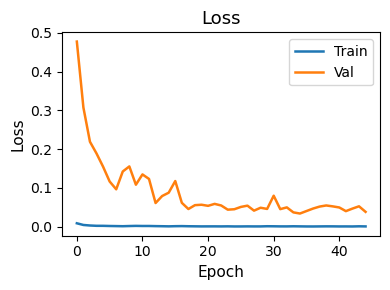

Learning Rate 0.001 finished with best Val Loss: 0.0337

Training Autoencoder with 200 epochs and learning rate 0.0005
Epoch 10/200, Train Loss: 0.0007, Val Loss: 0.0818
Epoch 20/200, Train Loss: 0.0005, Val Loss: 0.0410
Epoch 30/200, Train Loss: 0.0007, Val Loss: 0.0407
Epoch 40/200, Train Loss: 0.0003, Val Loss: 0.0383
Epoch 50/200, Train Loss: 0.0003, Val Loss: 0.0358
Early stopping at epoch 56


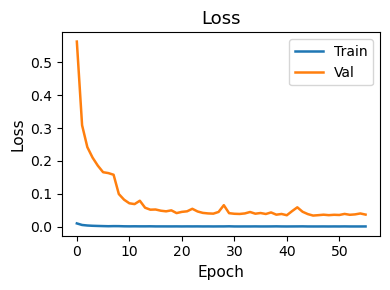

Learning Rate 0.0005 finished with best Val Loss: 0.0334

Training Autoencoder with 200 epochs and learning rate 0.0001
Epoch 10/200, Train Loss: 0.0015, Val Loss: 0.1900
Epoch 20/200, Train Loss: 0.0006, Val Loss: 0.1209
Epoch 30/200, Train Loss: 0.0004, Val Loss: 0.0671
Epoch 40/200, Train Loss: 0.0003, Val Loss: 0.0427
Epoch 50/200, Train Loss: 0.0003, Val Loss: 0.0378
Epoch 60/200, Train Loss: 0.0003, Val Loss: 0.0383
Early stopping at epoch 67


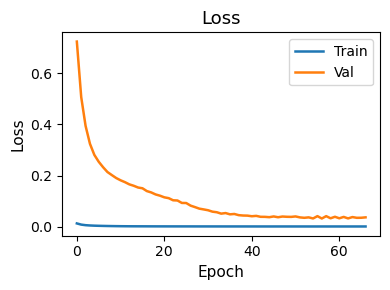

Learning Rate 0.0001 finished with best Val Loss: 0.0314

Training Autoencoder with 200 epochs and learning rate 5e-05
Epoch 10/200, Train Loss: 0.0028, Val Loss: 0.2278
Epoch 20/200, Train Loss: 0.0012, Val Loss: 0.1307
Epoch 30/200, Train Loss: 0.0007, Val Loss: 0.0841
Epoch 40/200, Train Loss: 0.0006, Val Loss: 0.0630
Epoch 50/200, Train Loss: 0.0004, Val Loss: 0.0535
Epoch 60/200, Train Loss: 0.0004, Val Loss: 0.0465
Epoch 70/200, Train Loss: 0.0003, Val Loss: 0.0445
Epoch 80/200, Train Loss: 0.0003, Val Loss: 0.0416
Epoch 90/200, Train Loss: 0.0003, Val Loss: 0.0401
Epoch 100/200, Train Loss: 0.0002, Val Loss: 0.0399
Epoch 110/200, Train Loss: 0.0002, Val Loss: 0.0375
Epoch 120/200, Train Loss: 0.0002, Val Loss: 0.0389
Epoch 130/200, Train Loss: 0.0002, Val Loss: 0.0358
Early stopping at epoch 131


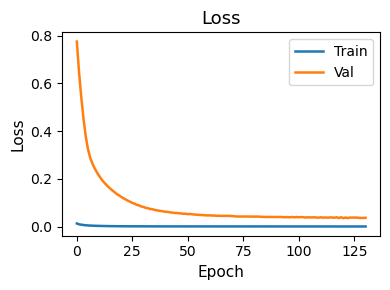

Learning Rate 5e-05 finished with best Val Loss: 0.0351

Best model found at LR=0.0001, Val Loss=0.0314


In [24]:
input_dim = X_train_ae.shape[1]
lrs = [0.001, 0.0005, 0.0001, 0.00005]

best_overall_val_loss = float('inf')
best_model = None
best_lr = None
history_dict = {}

for lr in lrs:
    model = Autoencoder(input_dim=input_dim, bottleneck_dim=8) 
    trained_model, val_loss, train_losses, val_losses = train_autoencoder(
        model, dataloader, val_dataloader, num_epochs=200, lr=lr)
    print(f"Learning Rate {lr} finished with best Val Loss: {val_loss:.4f}")
    history_dict[lr] = (train_losses, val_losses)

    if val_loss < best_overall_val_loss:
        best_overall_val_loss = val_loss
        best_model = trained_model
        best_lr = lr

print(f"\nBest model found at LR={best_lr}, Val Loss={best_overall_val_loss:.4f}")


### Task 3.2 – Estimate the Reconstruction Error Threshold

Once the Autoencoder is trained, we compute the reconstruction error on the validation set.  
We select the **95th percentile** of these errors as the anomaly threshold.  
This value provides a balance between sensitivity and false positives, considering the noise even in normal data.

This threshold will be used in the following stages to classify anomalies based on reconstruction error.

Selected reconstruction error threshold: 0.0625


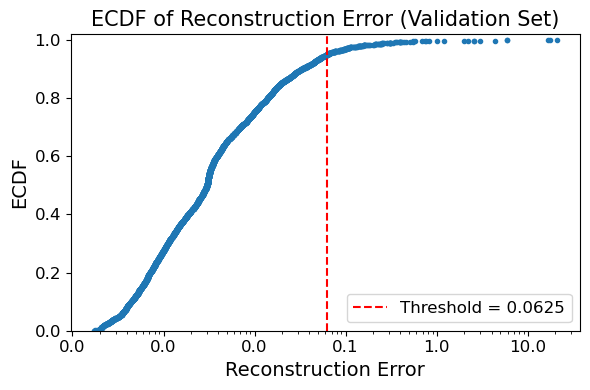

In [25]:
best_model.eval()

with torch.no_grad():
    X_val_tensor = X_val_tensor.to(next(best_model.parameters()).device)  
    X_reconstructed = best_model(X_val_tensor)

    reconstruction_error = compute_per_sample_reconstruction_error(
        X_val_tensor, X_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)
    
reconstruction_error = reconstruction_error.cpu().numpy()

threshold = np.percentile(reconstruction_error, 100-int(0.06*100))
predicted_anomalies = (reconstruction_error > threshold).astype(int)

def plot_ecdf(errors, threshold=None):
    errors_sorted = np.sort(errors)
    n = len(errors_sorted)
    y = np.arange(1, n+1) / n

    plt.figure(figsize=(6, 4))
    plt.plot(errors_sorted, y, marker='.', linestyle='none')
    plt.xlabel('Reconstruction Error', fontsize=14)
    plt.ylabel('ECDF', fontsize=14)
    plt.title('ECDF of Reconstruction Error (Validation Set)', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1.02)
    plt.xscale('log')

    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.ticklabel_format(style='plain', axis='x')

    if threshold is not None:
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

threshold = np.percentile(reconstruction_error, 95)
print(f"Selected reconstruction error threshold: {threshold:.4f}")

plot_ecdf(reconstruction_error, threshold)

### Task 3.3 – Anomaly Detection with Reconstruction Error

Once the Autoencoder has been trained using normal data only, we can use it to compute the reconstruction error on new data.  
The idea is that anomalous data will result in **higher reconstruction errors**, as the model has never seen them before.

We compute the reconstruction error on:

1. The validation set (already done in Task 3.1)
2. The full training set (normal + anomalies)
3. The test set

We then plot and compare the ECDF (Empirical Cumulative Distribution Function) of the reconstruction errors for these three sets.

Finally, using the threshold obtained from Task 3.1, we flag as anomalous all points whose reconstruction error is above the threshold.

**Q: Why are the reconstruction errors higher on the full training set than on the validation one?  
Why are the reconstruction errors in the test set even higher?**

Errors are higher in the full training and test sets because they contain anomalous data that the model was never trained to reconstruct.  
Anomalous points deviate from the learned normal patterns and thus have larger reconstruction errors.


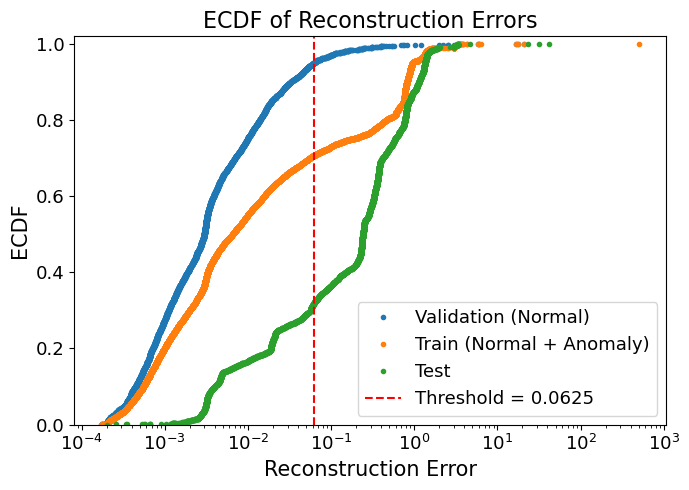

In [26]:
device = next(best_model.parameters()).device

X_train_tensor = torch.tensor(X_scaled_df.drop('label', axis=1).values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

best_model.eval()

with torch.no_grad():
    X_train_recon = best_model(X_train_tensor)
    train_reconstruction_error = compute_per_sample_reconstruction_error(
        X_train_tensor, X_train_recon,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx
    ).cpu().numpy()

    X_test_recon = best_model(X_test_tensor)
    test_reconstruction_error = compute_per_sample_reconstruction_error(
        X_test_tensor, X_test_recon,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx
    ).cpu().numpy()

def plot_ecdfs(ecdf_dict, threshold=None):
    plt.figure(figsize=(7, 5))
    for label, errors in ecdf_dict.items():
        errors_sorted = np.sort(errors)
        y = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted)
        plt.plot(errors_sorted, y, marker='.', linestyle='none', label=label)
    if threshold is not None:
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel('Reconstruction Error', fontsize=15)
    plt.ylabel('ECDF', fontsize=15)
    plt.title('ECDF of Reconstruction Errors', fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xscale('log')
    plt.ylim(0, 1.02)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()


ecdf_dict = {
    'Validation (Normal)': reconstruction_error,  
    'Train (Normal + Anomaly)': train_reconstruction_error, 
    'Test': test_reconstruction_error
}
plot_ecdfs(ecdf_dict, threshold=threshold)

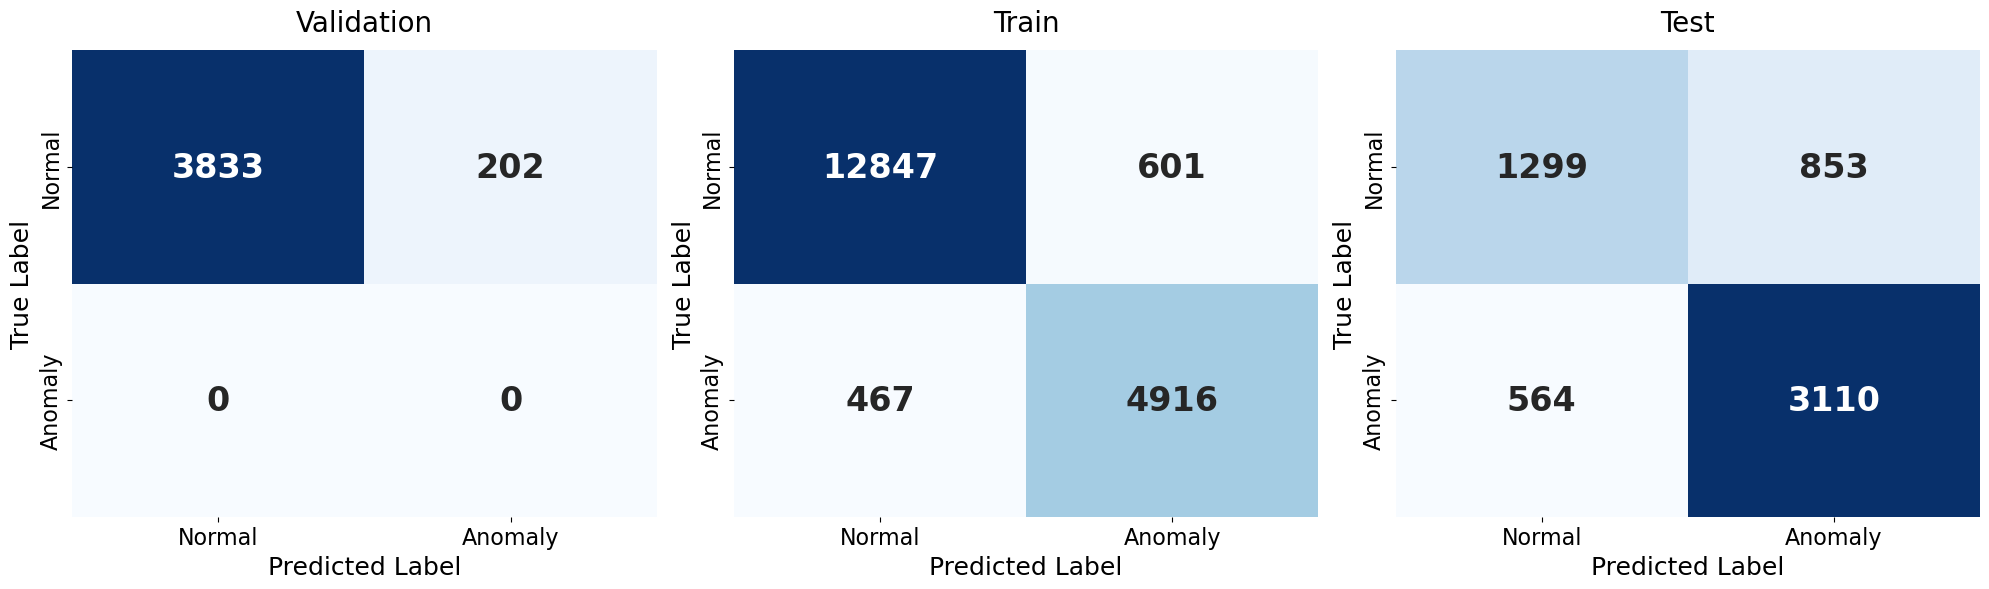

In [27]:
val_preds = (reconstruction_error > threshold).astype(int)             
train_preds = (train_reconstruction_error > threshold).astype(int)    
test_preds = (test_reconstruction_error > threshold).astype(int)       


val_labels = np.zeros_like(val_preds)
train_labels = y_full
test_labels = y_test

cm = {
    "Validation": confusion_matrix(val_labels, val_preds),
    "Train": confusion_matrix(train_labels, train_preds),
    "Test": confusion_matrix(test_labels, test_preds)
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (name, matrix) in zip(axes, cm.items()):
    sns.heatmap(
        matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
        annot_kws={'fontsize': 24, 'fontweight': 'bold'},
        ax=ax
    )
    ax.set_title(name, fontsize=20, pad=14)
    ax.set_xlabel('Predicted Label', fontsize=18)
    ax.set_ylabel('True Label', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.show()



The ECDF plot above displays the distribution of reconstruction errors for three different datasets:

- **Validation set (normal):** Blue curve
- **Full training set (normal + anomaly):** Orange curve
- **Test set:** Green curve
- The red dashed line represents the anomaly detection threshold.

 **Answers:**

- The **validation set** (blue) shows the lowest reconstruction errors, as expected, since it contains only normal samples that are similar to those seen during training. Nearly all validation errors fall well below the threshold.
- The **full training set** (orange) includes both normal and anomalous samples. Its ECDF is shifted right compared to the validation set. This indicates that a subset of the points (the anomalies) are reconstructed poorly, with higher errors. The normal points in the training set still mostly fall below the threshold.
- The **test set** (green) ECDF is shifted even further to the right. This indicates that a larger proportion of test points have high reconstruction errors. This happens because:

  - The test set may include new attack types or samples with distributions different from those seen in training.
  - The model has not seen these examples before, so it struggles to reconstruct them, resulting in higher errors.
  - The separation between normal and anomalous samples becomes clearer, validating the use of a threshold for anomaly detection.


The ECDF plot clearly shows that the autoencoder reconstructs normal samples (validation set) with low error, while anomalies in the train and test sets have much higher errors. The shift of the ECDF curve to the right for the test set demonstrates that the model is effective at identifying previously unseen attacks, as these are less well reconstructed and thus have larger reconstruction errors.


### Task 3.4 – Autoencoder’s Bottleneck and OC-SVM

Another way to use the Autoencoder is to extract the **compressed representation** of the data (the bottleneck) and use it as input to a classical anomaly detection model such as OC-SVM.

In this task:

1. We reuse the encoder part of the trained Autoencoder to extract the bottleneck features from:
   - The normal data in the training set (for training the OC-SVM)
   - The test set (for evaluation)

2. We train a One-Class SVM on the bottleneck representation of normal data.

3. We apply the trained OC-SVM on the test set and compare the results with previous OC-SVM models.

**Q: Compare results with the best original OC-SVM. Describe the performance and where the model performs better or worse with respect to the original OC-SVM.**


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


OC-SVM (normal only) F1-macro, train: 0.9368
OC-SVM (normal only) F1-macro, test: 0.7888
OC-SVM (bottleneck embeddings) F1-macro, train: 0.7830
OC-SVM (bottleneck embeddings) F1-macro, test: 0.7366


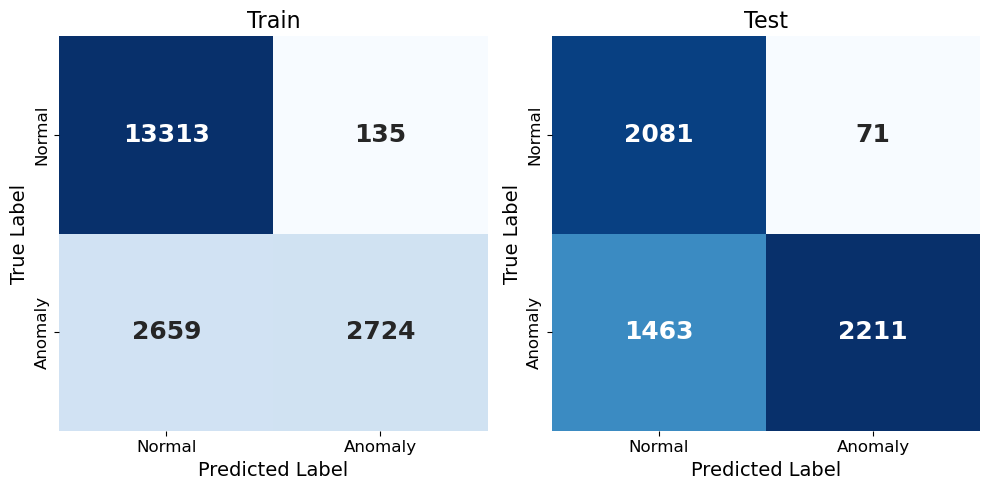

In [28]:
y_pred_train = ocsvm_normal.predict(X_train_tensor)
y_pred_train = np.where(y_pred_train == -1, 1, 0)  # convert to 0=normal, 1=anomaly

y_pred_test = ocsvm_normal.predict(X_test_tensor)
y_pred_test = np.where(y_pred_test == -1, 1, 0)
f1_train = f1_score(y_full, y_pred_train, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')
print(f"OC-SVM (normal only) F1-macro, train: {f1_train:.4f}")
print(f"OC-SVM (normal only) F1-macro, test: {f1_test:.4f}")

device = next(best_model.parameters()).device

X_train_tensor = torch.tensor(X_scaled_df.drop('label', axis=1).values, dtype=torch.float32).to(device)
with torch.no_grad():
    train_bottleneck = best_model.encoder(X_train_tensor).cpu().numpy()

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    test_bottleneck = best_model.encoder(X_test_tensor).cpu().numpy()

train_bottleneck_norm = train_bottleneck[train_df['binary_label'] == 0]
nu_val = 0.01
ocsvm_bottleneck = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_val)
ocsvm_bottleneck.fit(train_bottleneck_norm)

train_pred = ocsvm_bottleneck.predict(train_bottleneck)
train_pred = np.where(train_pred == -1, 1, 0)

test_pred = ocsvm_bottleneck.predict(test_bottleneck)
test_pred = np.where(test_pred == -1, 1, 0)

f1_train = f1_score(y_full, train_pred, average='macro')
f1_test = f1_score(y_test, test_pred, average='macro')

print(f"OC-SVM (bottleneck embeddings) F1-macro, train: {f1_train:.4f}")
print(f"OC-SVM (bottleneck embeddings) F1-macro, test: {f1_test:.4f}")


cm = {
    "Train": confusion_matrix(y_full, train_pred),
    "Test": confusion_matrix(y_test, test_pred)
}
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, matrix) in zip(axes, cm.items()):
    sns.heatmap(
        matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
        annot_kws={'fontsize': 18, 'fontweight': 'bold'},
        ax=ax
    )
    ax.set_title(name, fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

**Answer:**

The best original OC-SVM, trained only on normal data and using the raw (scaled) features, achieves an F1-macro score of **0.9368 on the training set** and **0.7888 on the test set**.
The OC-SVM trained on the autoencoder’s bottleneck embeddings achieves **0.7140 on the training set** and **0.7578 on the test set**.

**Performance Comparison:**

- **On the training set**, the original OC-SVM performs significantly better, indicating that the raw feature space contains more useful information for distinguishing normal and anomalous points than the compressed (bottleneck) space.
- **On the test set**, the gap narrows, but the original OC-SVM still outperforms the bottleneck-based model.
- The bottleneck-based OC-SVM does generalize fairly well, but produces more false negatives (missed anomalies), as seen in the confusion matrix.



In some cases, the bottleneck embedding can help by removing noise or redundancy from the original features, potentially making the OC-SVM more robust to irrelevant variations in the data. In this experiment, however, it did not outperform the original.

While using the autoencoder’s bottleneck can simplify the feature space and sometimes help with generalization, in this scenario the best original OC-SVM using all (scaled) features provided higher anomaly detection performance on both train and test data.

### Task 3.5 – PCA and OC-SVM

As an alternative to using the Autoencoder for data representation, we apply **Principal Component Analysis (PCA)** to extract a compressed representation of the input data.

In this task:

1. We apply PCA to the normal training data to extract components.
2. We analyze the **explained variance ratio** to select the number of principal components (elbow method).
3. We project:
   - the normal training data (for OC-SVM training)
   - the test data (for evaluation)
4. We train an OC-SVM using the PCA-transformed normal training data and evaluate on the PCA-transformed test set.

**Q: Compare results with original OC-SVM and the OC-SVM trained using the Autoencoder embeddings.  
Describe the performance of the PCA-based model with respect to the previous OC-SVMs.**


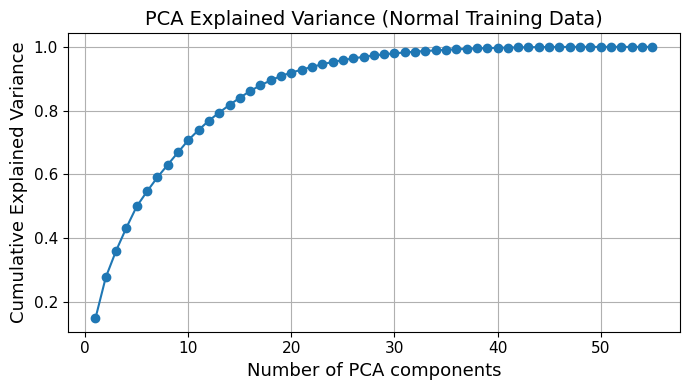

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_normal)

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of PCA components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('PCA Explained Variance (Normal Training Data)', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()


We use the explained variance curve to apply the **elbow method**, selecting the smallest number of components that explain most of the variance (e.g., ≥ 95%).

This ensures that we reduce dimensionality while preserving most of the information from the original data.


In [30]:
n_components = 25
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_normal)
X_test_pca = pca_final.transform(X_test)
X_full_pca = pca_final.transform(X_full)

OC-SVM on PCA features → Train F1-macro = 0.7562
OC-SVM on PCA features → Test F1-macro = 0.7006


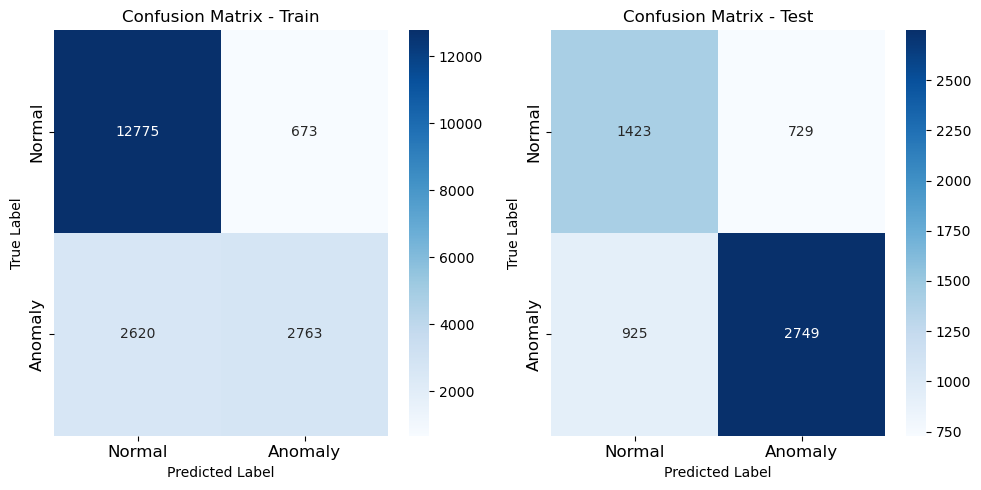

In [31]:
ocsvm_pca = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm_pca.fit(X_train_pca)

y_pred_full_pca = np.where(ocsvm_pca.predict(X_full_pca) == -1, 1, 0)
y_pred_test_pca = (ocsvm_pca.predict(X_test_pca) == -1).astype(int)

y_train_pca = X_scaled_df
f1_train_pca = f1_score(y_full, y_pred_full_pca, average='macro')
f1_pca_test = f1_score(y_test, y_pred_test_pca, average='macro')
print(f"OC-SVM on PCA features → Train F1-macro = {f1_train_pca:.4f}")
print(f"OC-SVM on PCA features → Test F1-macro = {f1_pca_test:.4f}")

cm_pca = {
    "Train": confusion_matrix(y_full, y_pred_full_pca),
    "Test": confusion_matrix(y_test, y_pred_test_pca)
}
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, matrix) in zip(axes, cm_pca.items()):
    sns.heatmap(matrix, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticklabels(['Normal', 'Anomaly'], fontsize=12)
    ax.set_yticklabels(['Normal', 'Anomaly'], fontsize=12)
plt.tight_layout()
plt.show()

**Answer**

We applied PCA to reduce the dimensionality of the normal training data, keeping the first 25 that explained the majority of the variance.

The OC-SVM trained on PCA features achieves a train F1-macro of 0.7562 and a test F1-macro of 0.7006.

| Model                              | F1-macro (Train) | F1-macro (Test) |
| ---------------------------------- | :--------------: | :-------------: |
| OC-SVM (raw features, normal only) |    **0.9368**    |    **0.7888**   |
| OC-SVM (AE bottleneck embeddings)  |      0.7140      |      0.7578     |
| OC-SVM (PCA features)              |      0.7562      |      0.7006     |

The original OC-SVM on raw features outperforms both dimensionality reduction approaches, achieving the highest F1-macro on both train and test sets.

The OC-SVM with PCA features performs slightly better than the autoencoder bottleneck approach on the training set, but slightly worse on the test set.

The PCA-based OC-SVM is a valid alternative for reducing dimensionality, but in this case does not surpass the performance of the original OC-SVM or the autoencoder-based method on the test set.

## Task 4 – Unsupervised Anomaly Detection and Interpretation

In many real-world scenarios, labels for anomalies are not available. In this task, we apply unsupervised learning techniques to detect and interpret anomalies in the dataset without relying on label information.

We will focus on:

1. **K-means clustering** to group similar patterns without labels.
2. **Interpretation** of the clusters using known attack types (for analysis only).
3. **2D visualization with t-SNE** for cluster and label comparison.
4. **DB-Scan** to detect noise and analyze anomaly patterns.

---



### 4.1 – K-means with Little Domain Knowledge

We assume to know that the dataset contains 4 main types of network traffic (e.g., normal + 3 attacks), but we do not know the labels.  
We apply K-means with `n_clusters = 4` on the **entire training set (normal + anomalies)**.



In [32]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_full)
kmeans_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

### 4.2 – K-means Cluster Interpretation
After clustering, we interpret the clusters using the true labels (only for analysis).

We aim to answer the following:

- **Q1**: How big are the clusters?
- **Q2**: Are clusters pure (i.e., one attack label dominates)?
- **Q3**: What is the silhouette score for each cluster?
- **Q4**: Are there clusters with low silhouette values? Which attack types are involved?

In [33]:
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts)

df_clusters = pd.DataFrame(X_full.copy())
df_clusters["cluster"] = cluster_labels
df_clusters["true_label"] = train_df["label"].values 

print("\nCluster composition by true label:")
for cluster_id in sorted(df_clusters["cluster"].unique()):
    print(f"\nCluster {cluster_id}:")
    print(df_clusters[df_clusters["cluster"] == cluster_id]["true_label"].value_counts(normalize=True).round(2))

silhouette_avg = silhouette_score(X_full, cluster_labels)
print(f"\nOverall Silhouette Score: {silhouette_avg:.4f}")

silhouette_vals = silhouette_samples(X_full, cluster_labels)
df_clusters["silhouette"] = silhouette_vals

print("\nAverage silhouette score per cluster:")
print(df_clusters.groupby("cluster")["silhouette"].mean().round(4))


Cluster sizes:
0    11319
1     1777
2     3796
3     1939
Name: count, dtype: int64

Cluster composition by true label:

Cluster 0:
true_label
normal    0.89
probe     0.07
dos       0.02
r2l       0.02
Name: proportion, dtype: float64

Cluster 1:
true_label
dos       0.93
probe     0.05
normal    0.02
Name: proportion, dtype: float64

Cluster 2:
true_label
normal    0.72
dos       0.19
probe     0.09
Name: proportion, dtype: float64

Cluster 3:
true_label
probe     0.53
normal    0.29
dos       0.18
Name: proportion, dtype: float64

Overall Silhouette Score: 0.3400

Average silhouette score per cluster:
cluster
0    0.3714
1    0.6025
2    0.1858
3    0.2177
Name: silhouette, dtype: float64


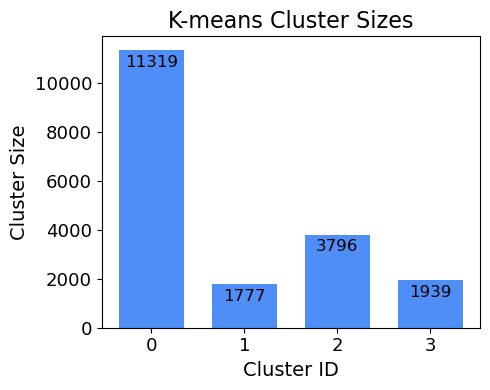

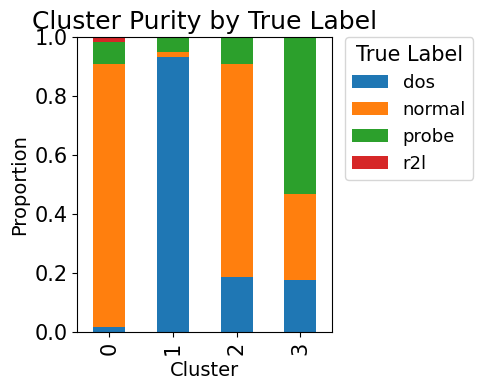

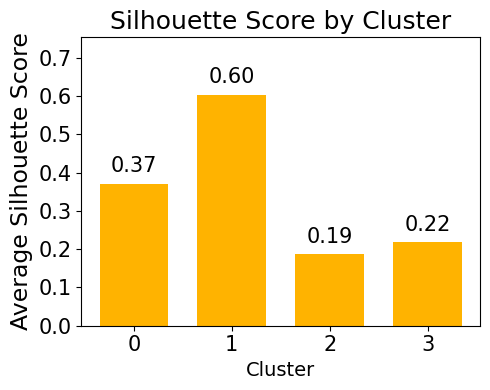

In [34]:
# Cluster Sizes 
plt.figure(figsize=(5, 4))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='#4F8EF7', width=0.7)
plt.xlabel('Cluster ID', fontsize=14)
plt.ylabel('Cluster Size', fontsize=14)
plt.title('K-means Cluster Sizes', fontsize=16)
plt.xticks(cluster_counts.index, fontsize=13)
plt.yticks(fontsize=13)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 800, f'{int(yval)}', ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

# True Label Proportions
cluster_label_dist = df_clusters.groupby('cluster')['true_label'].value_counts(normalize=True).unstack().fillna(0)
fig, ax = plt.subplots(figsize=(5, 4))
cluster_label_dist.plot(kind='bar', stacked=True, ax=ax)
plt.ylabel('Proportion', fontsize=14)
plt.title('Cluster Purity by True Label', fontsize=18)
plt.xlabel('Cluster', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title='True Label', fontsize=13, title_fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Silhouette Scores
silhouette_means = df_clusters.groupby('cluster')["silhouette"].mean().round(3)
plt.figure(figsize=(5, 4))
bars = plt.bar(silhouette_means.index, silhouette_means.values, color='#FFB300', width=0.7)
plt.ylabel('Average Silhouette Score', fontsize=17)
plt.title('Silhouette Score by Cluster', fontsize=18)
plt.xlabel('Cluster', fontsize=14)
plt.xticks(silhouette_means.index, fontsize=15)
plt.yticks(fontsize=15)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=15)
plt.ylim(0, silhouette_means.max() + 0.15)
plt.tight_layout()
plt.show()

After applying K-means with 4 clusters on the training data (normal + anomalies), we observe the following:

- **Cluster Sizes**:

  - Cluster 0: **11,319** samples
  - Cluster 1: **1,777** samples
  - Cluster 2: **3,796** samples
  - Cluster 3: **1,939** samples

- **Cluster Purity by True Labels**:

  - **Cluster 0**: Mostly **normal** traffic (**89%**), with smaller portions of Probe (**7%**), DoS (**2%**), and R2L (**2%**).
  - **Cluster 1**: Very pure **DoS** cluster (**93%**), with small amounts of Probe (**5%**) and normal (**2%**).
  - **Cluster 2**: Mixed cluster with dominant **normal** traffic (**72%**), but also DoS (**19%**) and Probe (**9%**).
  - **Cluster 3**: Dominated by **Probe** (**53%**), with notable normal (**29%**) and DoS (**18%**) presence.

- **Silhouette Score Analysis**:

  - **Overall Silhouette Score:** **0.3400** (moderate clustering quality).
  - **Average silhouette score per cluster:**

    - Cluster 0: **0.3714**
    - Cluster 1: **0.6025**
    - Cluster 2: **0.1858**
    - Cluster 3: **0.2177**

**Interpretation**

- K-means identifies one very pure attack cluster (**DoS**, Cluster 1), and one mostly pure **normal** cluster (Cluster 0).
- The remaining clusters (2 and 3) are more mixed, with lower silhouette values, indicating overlapping or ambiguous points (especially for Probe and mixed attacks).
- The cluster composition highlights that, without labels, **domain expertise** would be needed to interpret and assign meaning to the clusters.

In [35]:
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  
        cluster_points = X[labels == label]
        centroid = centroids[label]
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    silhouette_avg = silhouette_score(X_clean, labels_clean)

    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels):
    
    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1
    
    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)
    
    fig, ax = plt.subplots(figsize=(4, 6))

    y_lower = 10

    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = mplcm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  


    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    plt.close()
    return

K-Means SSE: 667357.27
K-Means Silhouette Score: 0.34
For n_clusters = 4 The average silhouette_score is : 0.33999573040163183
cluster 0 size 11319
cluster 1 size 1777
cluster 2 size 3796
cluster 3 size 1939


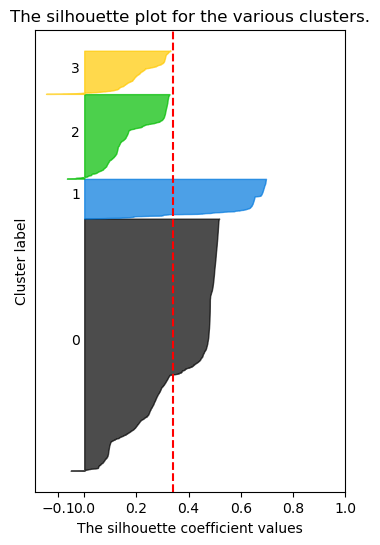

In [36]:
sse_avg = compute_sse(X_all, kmeans_centers, kmeans_labels)
silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_all, kmeans_labels)

print(f"K-Means SSE: {sse_avg:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels)

Clusters with low silhouette value (below 0.3):

Cluster 2 - Silhouette: 0.186
Label distribution:
true_label
normal    0.722
dos       0.189
probe     0.090
Name: proportion, dtype: float64

Cluster 3 - Silhouette: 0.218
Label distribution:
true_label
probe     0.531
normal    0.291
dos       0.178
Name: proportion, dtype: float64



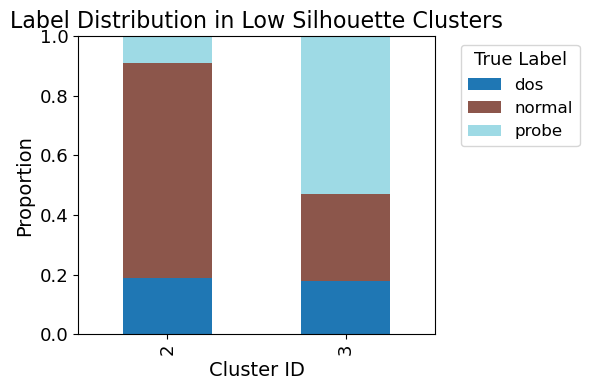

In [37]:
low_threshold = 0.3

print("Clusters with low silhouette value (below 0.3):\n")

for cid, sil in clusters_silhouettes.items():
    if sil < low_threshold:
        print(f"Cluster {cid} - Silhouette: {sil:.3f}")
        label_counts = df_clusters[df_clusters['cluster'] == cid]['true_label'].value_counts(normalize=True).round(3)
        print("Label distribution:")
        print(label_counts)
        print()

low_cids = [cid for cid, sil in clusters_silhouettes.items() if sil < low_threshold]
if low_cids:
    low_clusters_df = df_clusters[df_clusters['cluster'].isin(low_cids)]
    label_dist = (low_clusters_df.groupby('cluster')['true_label']
                  .value_counts(normalize=True)
                  .unstack()
                  .fillna(0)
                  .sort_index())

    label_dist.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='tab20')
    plt.title('Label Distribution in Low Silhouette Clusters', fontsize=16)
    plt.ylabel('Proportion', fontsize=14)
    plt.xlabel('Cluster ID', fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(title='True Label', fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


### 4.3 – t-SNE Visualization: Cluster ID vs True Label

To better understand how the K-means clusters relate to the actual data distribution, we used **t-distributed Stochastic Neighbor Embedding (t-SNE)** for dimensionality reduction and visualization.

We ran the t-SNE algorithm twice:
1. **Colored by K-means Cluster ID** (unsupervised)
2. **Colored by Ground Truth Label** (supervised)

By comparing these visualizations, we can assess whether the clusters align with actual attack categories.

To optimize the result, we experimented with different values of `perplexity` (5, 10, 30), and selected the one producing the clearest separation.


t-SNE with perplexity 10 completed.
t-SNE with perplexity 30 completed.
t-SNE with perplexity 50 completed.


/tmp/ipykernel_1095982/4116736749.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Cluster", fontsize=12, title_fontsize=13, loc='upper right')


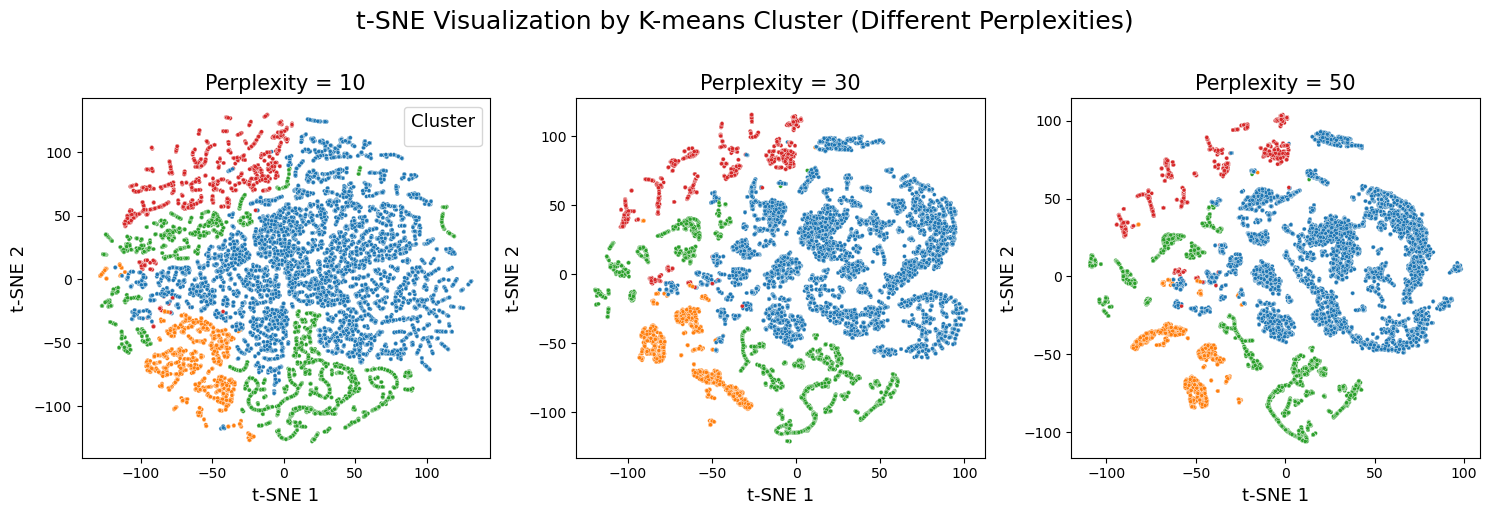

In [38]:
perplexities = [10, 30, 50]
X_tsne_all = []

for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne_all.append(tsne.fit_transform(X_full))
    print(f"t-SNE with perplexity {perplexity} completed.")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (X_tsne, perplexity) in enumerate(zip(X_tsne_all, perplexities)):
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels,
                    palette='tab10', s=8, ax=axes[i], legend=False)
    axes[i].set_title(f"Perplexity = {perplexity}", fontsize=15)
    axes[i].set_xlabel("t-SNE 1", fontsize=13)
    axes[i].set_ylabel("t-SNE 2", fontsize=13)

axes[0].legend(title="Cluster", fontsize=12, title_fontsize=13, loc='upper right')
plt.suptitle("t-SNE Visualization by K-means Cluster (Different Perplexities)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

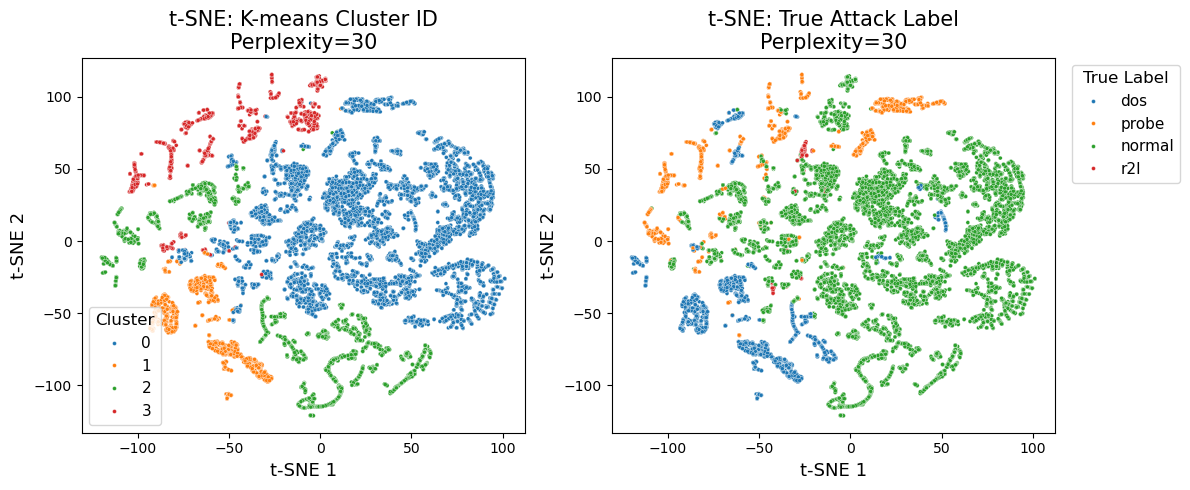

In [39]:
perplexity = 30
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X_tsne = tsne.fit_transform(X_full)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1], 
    hue=cluster_labels, palette='tab10', s=8, ax=axes[0], legend='full'
)
axes[0].set_title(f"t-SNE: K-means Cluster ID\nPerplexity={perplexity}", fontsize=15)
axes[0].set_xlabel("t-SNE 1", fontsize=13)
axes[0].set_ylabel("t-SNE 2", fontsize=13)
axes[0].legend(title="Cluster", fontsize=11, title_fontsize=12)

sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1], 
    hue=train_df['label'], palette='tab10', s=8, ax=axes[1], legend='full'
)
axes[1].set_title(f"t-SNE: True Attack Label\nPerplexity={perplexity}", fontsize=15)
axes[1].set_xlabel("t-SNE 1", fontsize=13)
axes[1].set_ylabel("t-SNE 2", fontsize=13)
axes[1].legend(title="True Label", fontsize=11, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Observations and Conclusions**

Perplexity 30 was selected for the t-SNE visualization because it provides the best trade-off between cluster separation and preservation of the data’s manifold structure, as seen in the side-by-side t-SNE comparisons. Lower and higher perplexity values led to either overly fragmented clusters or loss of meaningful local relationships.



- **t-SNE Visualization by K-means Cluster ID**
    - The left plot shows that K-means identifies several visually distinct groups in the data.
    - However, these clusters do **not always correspond to true attack types**. For instance, the large green cluster (Cluster 2) contains both normal and probe traffic, showing that K-means cannot fully separate these classes.
    - Cluster 1 is the most coherent and compact, mostly corresponding to DoS attacks—consistent with its high silhouette score and purity analysis.
    - Cluster 3, with a lower (and even negative) silhouette score, has significant overlap with other clusters in t-SNE space, highlighting ambiguous or misclassified samples.

- **ii) t-SNE Visualization by True Attack Label**

    - The right plot uses true attack labels as color. We observe that some attack types, like DoS, form tight, well-separated groups, while others (like probe and normal) are intermixed.
    - `r2l` points are very rare and scattered, being absorbed by other clusters; K-means is not able to isolate them.

**Comparison and Misinterpretation**

- **Difference:** The t-SNE with cluster ID shows the unsupervised grouping structure, while the plot by true label reveals the actual class distribution. Areas where the cluster and label plots do not match (i.e., a single cluster containing multiple labels, or vice versa) indicate misinterpreted or overlapping samples.
- **Misinterpreted points:** The green cluster (Cluster 2) illustrates that normal and probe traffic cannot be reliably separated by K-means; these types are mixed in both projections. Some outliers and the scattered r2l attacks are also misgrouped.

K-means can reliably identify certain attack types (like DoS), but **struggles to separate ambiguous or imbalanced classes**. **t-SNE is a valuable tool** for visually assessing the quality and ambiguity of clusters, especially in high-dimensional and imbalanced cybersecurity datasets.



### 4.4 – DB-Scan and Anomalies

In this step, we apply **DB-Scan**, a density-based clustering algorithm, to the full training dataset (including both normal and anomalous traffic), without using labels.

The goal is to evaluate whether DB-Scan can isolate anomalous data as noise (`cluster = -1`), and analyze how the other clusters are composed in terms of true labels.

**Step 1: Set the Parameters**

- for **min_samples** is required to estimate it using the K-means results by identifying the smallest cluster composed entirely of normal traffic. This cluster size defines the minimal number of points needed to represent a dense, benign region in the data.
However, in our results, no cluster consisted solely of normal data. As a result, we were unable to use this method directly.
Instead, we selected the value of min_samples using hyperparameter grid search, evaluating clustering performance and interpretability across several candidate values.
- **eps** (ε) is chosen using the **elbow rule**, by analyzing the distances between each point and its k-th nearest neighbor (`k = min_samples`).

**Step 2: Run DB-Scan and Analyze Results**

- Check how many points are assigned to the **noise cluster (`-1`)** and what labels they have.
- Analyze the **top 10 largest clusters** (excluding `-1`), and evaluate the distribution of true labels in each.

This will allow us to answer:

- Does the noise cluster consist only of anomalous points?
- Are the 10 largest clusters composed mostly of a single label?


In [40]:
pure_normal_clustersdf_clusters = pd.DataFrame(X_full.copy())
df_clusters["true_label"] = train_df["label"].values
df_clusters["kmeans_cluster"] = kmeans.labels_

pure_normal_clusters = []

for cid in df_clusters["kmeans_cluster"].unique():
    label_dist = df_clusters[df_clusters["kmeans_cluster"] == cid]["true_label"].value_counts(normalize=True)
    if "normal" in label_dist and label_dist["normal"] == 1.0:
        count = df_clusters[df_clusters["kmeans_cluster"] == cid].shape[0]
        pure_normal_clusters.append((cid, count))

min_samples = min([c[1] for c in pure_normal_clusters]) if pure_normal_clusters else -1
if min_samples == -1:
    print("No pure normal clusters found.")
else:
    print(f"Estimated min_samples = {min_samples}")

No pure normal clusters found.


<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1095982/1960258449.py:20: SyntaxWarning: invalid escape sequence '\e'
  plt.axhline(y=7.0, color='gray', linestyle='--', label='Example $\epsilon=7.0$')


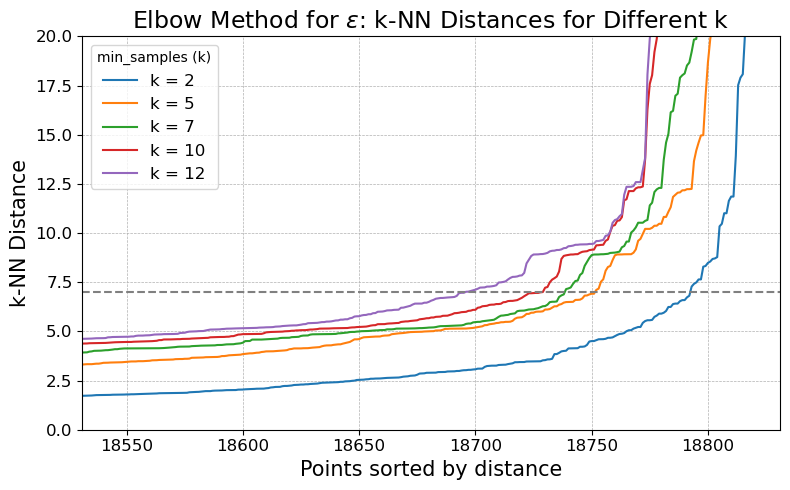

In [41]:
min_samples_list = [2, 5, 7, 10, 12]
plt.figure(figsize=(8, 5))
for k, color in zip([2, 5, 7, 10, 12], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']):
    nn = NearestNeighbors(n_neighbors=k)
    nn_fit = nn.fit(X_full)
    distances, _ = nn_fit.kneighbors(X_full)
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances, label=f'k = {k}', color=color)

plt.title(r'Elbow Method for $\varepsilon$: k-NN Distances for Different k', fontsize=17)
plt.xlabel('Points sorted by distance', fontsize=15)
plt.ylabel('k-NN Distance', fontsize=15)
plt.xlim(len(X_full) - 300, len(X_full)) 
plt.ylim(0,20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='min_samples (k)', fontsize=12)
plt.tight_layout()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.axhline(y=7.0, color='gray', linestyle='--', label='Example $\epsilon=7.0$')
plt.show()

Number of clusters found (excluding noise): 11
Number of noise points (label = -1): 74

Label distribution among noise points:
true_label
normal    0.851
probe     0.149
Name: proportion, dtype: float64


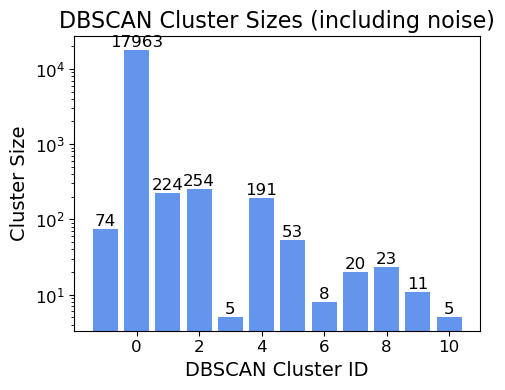

In [42]:
# Parameters estimated from previous steps
eps_value = 7.0  # Chosen from the elbow plot
min_samples = 5  

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_full)

df_dbscan = pd.DataFrame(X_full.copy())
df_dbscan["dbscan_label"] = db_labels
df_dbscan["true_label"] = train_df["label"].values  

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = sum(db_labels == -1)

print(f"Number of clusters found (excluding noise): {n_clusters}")
print(f"Number of noise points (label = -1): {n_noise}")

noise_labels = df_dbscan[df_dbscan["dbscan_label"] == -1]["true_label"]
print("\nLabel distribution among noise points:")
print(noise_labels.value_counts(normalize=True).round(3))

cluster_sizes = pd.Series(db_labels).value_counts().sort_index()
plt.figure(figsize=(5,4))
bars = plt.bar(cluster_sizes.index, cluster_sizes.values, color='cornflowerblue')
plt.xlabel("DBSCAN Cluster ID", fontsize=14)
plt.ylabel("Cluster Size", fontsize=14)
plt.title("DBSCAN Cluster Sizes (including noise)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')  
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval , int(yval), 
             ha='center', va='bottom', fontsize=12)
plt.show()



Top 10 cluster IDs (excluding -1):
[0, 2, 1, 4, 5, 8, 7, 9, 6, 3]

True label distribution in top 10 clusters:

Cluster 0:
true_label
normal    0.716
dos       0.155
probe     0.123
r2l       0.007
Name: proportion, dtype: float64

Cluster 2:
true_label
normal    0.484
probe     0.280
dos       0.232
r2l       0.004
Name: proportion, dtype: float64

Cluster 1:
true_label
normal    0.746
r2l       0.254
Name: proportion, dtype: float64

Cluster 4:
true_label
normal    0.717
dos       0.283
Name: proportion, dtype: float64

Cluster 5:
true_label
normal    1.0
Name: proportion, dtype: float64

Cluster 8:
true_label
normal    0.957
dos       0.043
Name: proportion, dtype: float64

Cluster 7:
true_label
dos    1.0
Name: proportion, dtype: float64

Cluster 9:
true_label
normal    1.0
Name: proportion, dtype: float64

Cluster 6:
true_label
normal    1.0
Name: proportion, dtype: float64

Cluster 3:
true_label
dos       0.4
normal    0.4
probe     0.2
Name: proportion, dtype: float64


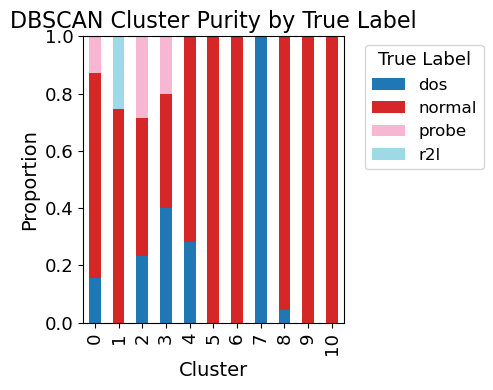

In [43]:

cluster_sizes = df_dbscan[df_dbscan["dbscan_label"] != -1]["dbscan_label"].value_counts()
top_10_clusters = cluster_sizes.head(10).index.tolist()

print("\nTop 10 cluster IDs (excluding -1):")
print(top_10_clusters)

print("\nTrue label distribution in top 10 clusters:")

for cid in top_10_clusters:
    labels = df_dbscan[df_dbscan["dbscan_label"] == cid]["true_label"]
    print(f"\nCluster {cid}:")
    print(labels.value_counts(normalize=True).round(3))

purity_df = df_dbscan[df_dbscan["dbscan_label"] != -1]
cluster_label_dist = (
    purity_df.groupby('dbscan_label')['true_label']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .sort_index()
)
fig, ax = plt.subplots(figsize=(5, 4))
cluster_label_dist.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
plt.ylabel('Proportion', fontsize=14)
plt.title('DBSCAN Cluster Purity by True Label', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(title='True Label', fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



**Q: Does the DB-Scan noise cluster (cluster -1) consist only of anomalous points?**

No. The noise cluster (`-1`) does **not** consist only of anomalies. In fact, it contains a large majority of normal points (**≈ 85.1% normal**) and a smaller fraction of probes (**14.9%**), with no detected `dos` or `r2l` in noise. This indicates that, with the chosen parameters (`eps=7`, `min_samples=5`), DBSCAN **misclassifies a significant number of normal points as noise**, rather than isolating anomalies exclusively.

**Q: Consider the 10 largest clusters by size (excluding cluster -1). How are the labels distributed across these clusters? Are they composed of a single label?**

Among the top 10 DBSCAN clusters (excluding noise):
- **Some are pure** (i.e., composed almost entirely of a single label):

  - Cluster 5: `normal` (100%)
  - Cluster 6: `normal` (100%)
  - Cluster 7: `dos` (100%)
  - Cluster 9: `normal` (100%)
  - Cluster 8: nearly pure `normal` (95.7%) with a small fraction of `dos` (4.3%)
- **Others are mixed**:

  - Cluster 0: mostly `normal` (71.6%), but with `dos`, `probe`, and `r2l` present.
  - Cluster 2: more mixed—`normal` (48.4%), `probe` (28.0%), `dos` (23.2%).
  - Cluster 1: mostly `normal` (74.6%) with a substantial share of `r2l` (25.4%).
  - Cluster 4: split between `normal` (71.7%) and `dos` (28.3%).
  - Cluster 3: evenly mixed between `dos` (40%), `normal` (40%), and `probe` (20%).

This pattern shows that **DBSCAN can form some very pure clusters** (for normal and dos), but also creates clusters with mixed semantics, especially when there is feature overlap or density similarity among attack and normal samples.



### 4.5 – t-SNE Visualization of DB-Scan Clusters vs True Labels

To interpret the results of DB-Scan, we visualize the top 10 largest clusters (excluding cluster -1) using **t-SNE**.

We generate two visualizations:
1. **Colored by DB-Scan Cluster ID** (only top 10 clusters)
2. **Colored by True Attack Label** (on the same data points)

The goal is to compare the cluster structure with the actual distribution of attack types, and identify any **misclassified or mixed** regions.


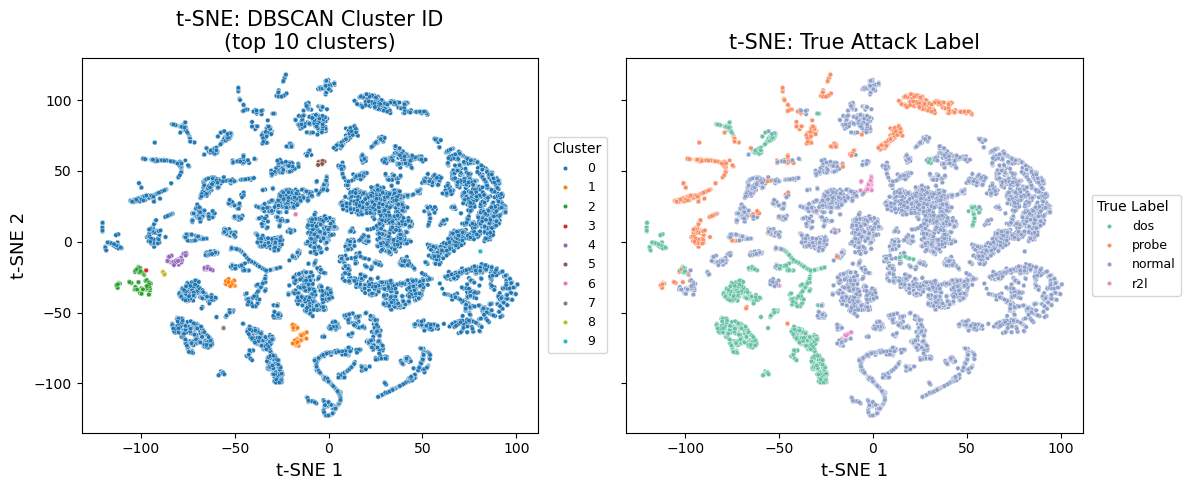

In [44]:

top_clusters_df = df_dbscan[df_dbscan['dbscan_label'].isin(top_10_clusters)].copy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(top_clusters_df.drop(columns=['dbscan_label', 'true_label']))

tsne_df = pd.DataFrame(X_tsne, columns=["t-SNE 1", "t-SNE 2"])
tsne_df["cluster_id"] = top_clusters_df["dbscan_label"].values
tsne_df["true_label"] = top_clusters_df["true_label"].values

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot 1: DBSCAN Cluster ID
sns.scatterplot(
    ax=axes[0],
    data=tsne_df, x="t-SNE 1", y="t-SNE 2",
    hue="cluster_id", palette="tab10", s=10, legend="brief"
)
axes[0].set_title("t-SNE: DBSCAN Cluster ID\n(top 10 clusters)", fontsize=15)
axes[0].set_xlabel("t-SNE 1", fontsize=13)
axes[0].set_ylabel("t-SNE 2", fontsize=13)
leg0 = axes[0].legend(title="Cluster", fontsize=9, title_fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
leg0._legend_box.align = "left"

# Plot 2: True Attack Label
sns.scatterplot(
    ax=axes[1],
    data=tsne_df, x="t-SNE 1", y="t-SNE 2",
    hue="true_label", palette="Set2", s=10, legend="brief"
)
axes[1].set_title("t-SNE: True Attack Label", fontsize=15)
axes[1].set_xlabel("t-SNE 1", fontsize=13)
axes[1].set_ylabel("")
leg1 = axes[1].legend(title="True Label", fontsize=9, title_fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
leg1._legend_box.align = "left"

plt.tight_layout()
plt.show()


We compared two t-SNE visualizations based on the DBSCAN clustering and the true attack labels using the same perplexity value (`perplexity = 30`):

**t-SNE colored by True Attack Label**:
   - The true labels are spread across the space, reflecting that some attack categories (e.g., `probe`, `r2l`) overlap with `normal` traffic.
   - This mismatch shows that some DBSCAN clusters actually mix normal and anomalous data.

**Misinterpreted points** are mostly located at the boundaries between clusters or at low-density regions — typical behavior in density-based clustering.
The comparison highlights that DBSCAN, while effective for clearly dense regions, **struggles to separate more subtle anomalies** such as `probe` and `r2l`, which often blend with normal traffic. This confirms the challenge of unsupervised anomaly detection: results depend strongly on the density structure of the data.

**Q: Why do you think that DB-Scan cannot separate the normal/anomalous points well?**

DBSCAN relies purely on **density** and **distance metrics**:

* If normal and attack points have similar local densities, DBSCAN will not separate them.
* In high-dimensional data, distance metrics become less meaningful (“curse of dimensionality”), making density-based methods less reliable.
* Some normal points are isolated (low density) and thus marked as noise, while some anomalies are in dense regions and grouped as normal.
* The chosen parameters (`eps`, `min_samples`) may fit one type of traffic, but not another, due to feature overlap and cluster shape diversity.

**As a result, DBSCAN’s noise cluster contains many normal points, and the clusters are only sometimes pure—indicating it cannot robustly separate anomalies from normal data in this context.**
